<h1><center>Machine Learning for Natural Language Processing</center></h1>

Course of ML for Finance - 
Benjamin Muller $-$ ENSAE 3rd year  
$\texttt{paul.couairon@ensae.fr}$ ⎜ $\texttt{loic.jourdan@ensae.fr}$ 


## Table of Contents
1. [Introduction]
2. [Preprocessing et Analyse Descriptive]
    1. [Cmp_code]
    2. [Texte]
    3. [Distribution du vocabulaire]
    4. [Distance entre les dictionnaires]
    5. [Classification manuelle]
3. [Modèles de Machine Learning]
    1. [Benchmark de modèles]
    2. [L'exemple du Support Vector Classifier]
    3. [Approche $n$-grams]
4. [Modèles d'apprentissage profond]
    1. [Réseaux Long Short Term Memory (LSTM)]
    2. [LSTM et Word2Vec]
    3. [FastText]
    4. [LSTM et FastText]
    5. [GRU et FastText]
5. [Deep Neural Network et Universal Sentence Encoder]


# 1. Introduction

Dans le champ d’étude des partis politiques, le débat permanent d'idées qui agite les différentes composantes de la vie politique, met en lumière leurs dissensions autour des nombreux enjeux que constituent la mise en place de politiques publiques, leurs intérêts ou encore leurs priorités politiques. Pour Piet, Dandoy et Joly dans un article publié en 2015 intitulé <ins>"Comprendre le contenu des programmes électoraux"</ins>, la priorité politique peut être définie comme le poids relatif d'un thème dans un programme électoral. En effet un programme aborde une grande diversité de problématiques et le développement de chacune d'entre elles ne peut faire l'objet de la même attention. Ainsi, il est raisonnable d'estimer qu'un parti écologiste fasse de l'enjeu environnemental sa priorité, tandis qu'un parti socialiste fasse des thématiques sociales son cheval de bataille. Une analyse approfondie de ces programmes politiques, synthétisant l'ensemble des engagements et thèmes des différents partis, permet alors de prendre la mesure des divergences idéologiques ainsi que leurs évolutions. Le **Comparative Manifesto Project** vise à faire cela. Ce projet a en effet pour objectif de recenser les différents éléments proposés dans les programmes de la plupart des partis présentant des candidats aux élections législatives. Un programme est alors décomposé en unités de sens, et chacune d'entre elles est annotée manuellement par une équipe de codeurs. 

Ces données recensées par le **Comparative Manifesto Project** forment la base de notre analyse comparative des programmes des partis politiques. L'équipe de codeurs fait émerger de ces textes plusieurs catégories de thèmes, chacune de ces catégories ayant un code bien précis. Ainsi, une petite partie de la base de données est annotée de cette manière, mais ce travail est coûteux en terme de temps et fastidieux. La question qui se pose alors est la suivante: Pouvons-nous, à l'aide de méthodes d'apprentissage statistique du langage, répliquer la manière dont les codeurs ont attribués les catégories aux unités de sens? C'est-à-dire, nous nous demandons si nous sommes en mesure d'implémenter des algorithmes de Natural Language Processing qui permettent d'encoder automatiquement les unités de sens de programmes politiques. Dans le cas contraire quelle est la fiabilité de notre encodage automatique vis à vis de celui effectué manuellement?

Afin de répondre à ces questions, nous effectuons en premier lieu une analyse descriptive approfondie de la base de données. Nous cherchons ainsi à évaluer la taille du vocabulaire utilisé, la répartition de celui-ci au sein des catégories, la distance entre les dictionnaires des catégories, etc. Afin d'effectuer la transition vers les modèles d'apprentissage, nous présentons ensuite quelques méthodes classiques d'embeddings qui permettent de représenter le vocabulaire sous forme de vecteurs. Cette nouvelle représentation a ceci de particulier que des mots apparaissant dans des contextes similaires possèdent des vecteurs correspondant relativement proches. Les représentations vectorielles nous permettent d'une part d'implémenter des algorithmes classiques d'apprentissage sur des agrégations simples d'embeddings. D'autre part, nous développons nos propres modèles d'apprentissage profond dont la plus grande complexité permettrait d'améliorer les résultats obtenus. Finalement, nous utilisons un modèle dont les représentations vectorielles sont pré-entraînées, que nous ajustons sur nos données. Ce modèle censé avoir un compréhension très fine du flux linguistique devrait nous permettre d'améliorer davantage nos résultats de classification. 


# 2. Preprocessing et Analyse Descriptive
## 2.1 Cmp_code

Au regard de la richesse des données proposée par le **Comparative Manifesto Project**, nous choisissons de restreindre notre analyse sur les élections ayant eu lieu au Royaume-Uni entre 2015 et 2019. D'une part, les données que nous manipulons sont en anglais, ce qui nous permet de valider ou d'infirmer aisément les résultats que nous obtenons. D'autre part, la période de temps considérée, bien que relativement courte nous offre suffisamment de données pour mener à bien une analyse cohérente. En revanche le climat politique relativement agité au cours de cette période (dû notamment à la sortie du Royaume-Uni de l'Europe) peut éventuellement influencer notre analyse, les discours étant sujets à varier selon les nouveaux enjeux auxquels doivent faire face les responsables politiques. Aussi, les données sur lesquelles nous travaillons sont des données textuelles, non structurées, c'est à dire qui n'ont pas de format pré-défini ni organisée d'une manière particulière. Un travail de nettoyage des données constitue donc le premier temps de notre démarche et est déterminant dans l'objectif d'établir des modèles performants. Afin d'illustrer nos propos par la suite, voici un exemple de données extraites de la base.

In [50]:
import pandas as pd
import numpy as np
import gensim
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
import seaborn as sns
sns.set_style({'grid.linestyle': '--'})

In [2]:
import nltk
import spacy
import keras

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.collocations import *
from nltk.util import everygrams

try:
    stopwords = set(stopwords.words('english'))
except LookupError:
    import nltk
    nltk.download('stopwords')
    stopwords = set(stopwords.words('english'))
#stopwords

In [3]:
df = pd.read_csv("./ManifestoUK.csv", encoding = "latin1")

In [21]:
df.tail()

,Unnamed: 0,text,cmp_code,eu_code,pos
24740,24741,UKIP will review the many statutory duties pla...,303,NaN,1416
24741,24742,Councils should only be doing what they do bes...,303,NaN,1417
24742,24743,"UKIP: the party with local, common sense, cost...",303,NaN,1418
24743,24744,UKIPs Five Year Fiscal Plan,NaN,NaN,1419
24744,24745,All figures in £bn,NaN,NaN,1420


In [22]:
# Nous retirons les colonnes qui ne nous intéressent pas. 
df = df.drop(columns = ["Unnamed: 0", "eu_code"])

In [23]:
# Nous voulons prédire la colonne 'cmp_code'. Observons ses caractéristiques. 
print(df['cmp_code'].describe())

k = df['cmp_code'].isna().sum()
p = df['cmp_code'].isna().sum()/np.shape(df['cmp_code'])[0]

print('Nombre de NaNs: {:3} soit {:2.2%}'.format(k, p))

count     22456
unique       82
top         504
freq       2691
Name: cmp_code, dtype: object
Number of NaNs: 2289 soit 9.25%


Nous nous intéressons tout d'abord à la variable **cmp_code** qui est la variable que nous allons chercher à prédire grâce aux données de la variable **text**. Il existe certaines unités de sens de la base pour lesquelles aucun code n'est attribué, si bien qu'il sera impossible pour nous en les conservant de vérifier si nos prédictions sont valides pour ces observations. Ces valeurs manquantes représentent environ 9% du nombre total d'observations de la base de données, soit 2289 observations sur 24744. Le nombre total d'observations étant suffisamment conséquent, nous choisissons de supprimer purement et simplement les observations dont les **cmp_code** sont manquants, cela n'affectera pas outre mesure les performances des modèles que nous développerons. 

In [24]:
# Nous retirons les NaNs ainsi que les cmp_code égaux à 'H'.

df = df[df["cmp_code"] == df["cmp_code"]]
df = df[df["cmp_code"] != "H"]
df = df[df["cmp_code"] != '000'].reset_index(drop = True)

In [25]:
# Les 'cmp_code' sont initialement sous forme de strings. Nous retirons donc ceux qui ne sont pas sous cette forme. 
index = []

for i in range(np.shape(df)[0]):
    if type(df["text"][i]) != str:
        index.append(i)
        
df = df.drop(index).reset_index(drop = True)

Les **cmp_code** se présentent sous la forme de nombres à 3 chiffres, le premier d'entre eux désignant le thème principal de l'unité de sens associée. Par exemple, une phrase dont le premier chiffre du code est 1, aborde le sujet des *"Relations extérieures"*. Le chiffre 2 correspond à *"Liberté et Démocratie"*, le chiffre 3 est attribué à la catégorie *"Système politique"*, le chiffre 4 traite de *"l'Economie"*, le chiffre 5 correspond à la catégorie *"Bien être et qualité de vie"*, le chiffre 6 au thème *"Vie en société"* (mode de vie, multiculturalisme, esprit civique...) et 7 aux *"Groupes sociaux"* (agriculteurs, classe moyenne...). Ainsi les sujets traités dans les unités de sens sont répartis en sept thèmes, eux-mêmes subdivisés en sous-catégories. Les deux autres chiffres du **cmp_code** désignent alors la sous-catégorie au sein du thème principal. En considérant l'ensemble des catégories et sous-catégories, nous comptons 82 codes différents.


Aussi, nous voulons connaître la répartition de ces catégories au sein de la base afin de déterminer si certaines d'entre elles sont sur-représentées ou sous-représentées. Le cas échéant, les modèles que nous construirons prédiront bien les items appartenant aux classes les plus représentées mais peineront pour apprendre correctement les items dont les labels sont sous-représentés. 

In [26]:
# Nous créons une nouvelle catégorie correspondant au premier chiffre du cmp_code.
df['category_1'] = df["cmp_code"].apply(lambda x: int(x[0]))

In [27]:
# Nous transformons les codes en float.

codes = list(df['cmp_code'])
label = []
for code in codes:
    label.append(float(code))

df["cmp_code"] = label

Text(0, 0.5, 'Frequency')

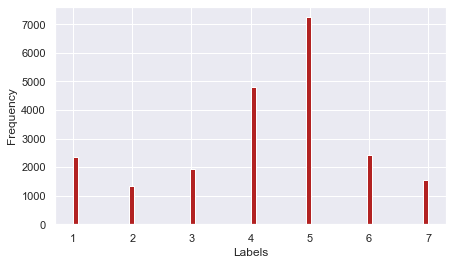

In [28]:
# Distribution des cmp_code
fig = plt.figure(figsize = (7, 4))
df['category_1'].hist(color = 'firebrick', bins = 70)
plt.xlabel('Labels')
plt.ylabel('Frequency')
#fig.savefig('Categories.pdf')

Nous pouvons observer la répartition de ces labels grâce à la figure 2. Nous remarquons que les catégories 4 et 5 sont les plus représentées avec respectivement plus de 4000 et 7000 unités de sens. Les autres catégories comptent entre 1000 et 2500 unités de sens; la catégorie 2 qui est la moins représentée compte ainsi environ 5 fois moins d'observations que la 5.  Cette distribution des labels nous laisse donc présager que nos modèles auront de meilleurs résultats sur les classes 4 et 5 que sur les autres classes. 


## Texte

In [31]:
# Nous commençons par lemmatizer le texte avec du POS tagging

from nltk.corpus import wordnet as wn

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wn.ADJ,
                "N": wn.NOUN,
                "V": wn.VERB,
                "R": wn.ADV}

    return tag_dict.get(tag, wn.NOUN)

In [32]:
import re
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer() 

# Nous définissons une fonction qui nettoie le texte en retirant les pronoms personnels, les stopwords et la ponctuation.
def cleanup_text(df, logging=False):
    texts = []
    words = []
    low = []
    
    docs = df['text']
    
    for doc in tqdm(docs):
        doc = re.sub('[^A-Za-z]+', " ", doc)
        doc = keras.preprocessing.text.text_to_word_sequence(doc, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ')
        
        doc = ' '.join(doc)
        
        doc = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(doc)]
        
        tokens = [tok.lower() for tok in doc if tok not in stopwords]
        tok_2 = [tok.lower() for tok in doc]
        word = tokens
        words.append(word)
        
        tokens = ' '.join(tokens)
        tok_2 = ' '.join(tok_2)
        texts.append(tokens)
        low.append(tok_2)
    
    df['words'] = pd.Series(words)
    df['lem_sent'] = pd.Series(texts)
    df['lower'] = pd.Series(low)
    return df

In [33]:
cleanup_text(df)

100%|██████████| 21667/21667 [01:01<00:00, 354.41it/s]


,text,cmp_code,pos,category_1,words,lem_sent,lower
0,We face three connected crises: Healing the pl...,416.0,16,4,"[face, three, connect, crisis, heal, planet, e...",face three connect crisis heal planet effect u...,we face three connect crisis heal the planet f...
1,"Creating a more equal society, reversing the t...",503.0,17,5,"[create, equal, society, reverse, trend, towar...",create equal society reverse trend towards soc...,create a more equal society reverse the trend ...
2,Creating truly democratic central and local go...,202.0,18,2,"[create, truly, democratic, central, local, go...",create truly democratic central local governme...,create truly democratic central and local gove...
3,To help heal the planet we will: Make achievin...,501.0,19,5,"[help, heal, planet, make, achieve, internatio...",help heal planet make achieve international ag...,to help heal the planet we will make achieve i...
4,Invest in an £85 billion public programme of r...,501.0,20,5,"[invest, billion, public, programme, renewable...",invest billion public programme renewable elec...,invest in an billion public programme of renew...
...,...,...,...,...,...,...,...
21662,UKIP will end the use of council procurement c...,303.0,1414,3,"[ukip, end, use, council, procurement, card, o...",ukip end use council procurement card operate ...,ukip will end the use of council procurement c...
21663,Staff should stick within agreed budgets.,303.0,1415,3,"[staff, stick, within, agree, budget]",staff stick within agree budget,staff should stick within agree budget
21664,UKIP will review the many statutory duties pla...,303.0,1416,3,"[ukip, review, many, statutory, duty, place, l...",ukip review many statutory duty place local go...,ukip will review the many statutory duty place...
21665,Councils should only be doing what they do bes...,303.0,1417,3,"[council, best, national, government, want, wa...",council best national government want wash hand,council should only be do what they do best no...


In [34]:
# Nous gardons uniquement les phrases qui ne sont pas vides. 
df = df[df['lem_sent'].apply(lambda x: len(x)>0)].reset_index(drop=True)

Une étape importante dans le preprocessing des données en traitement automatique du language est la suppression des stop-words. Ceux-ci font référence aux mots les plus communs d'une langue, qui sont principalement des mots grammaticaux comme des articles, des prépositions ou des pronoms (par exemple *the, at, which, and...* en anglais). Contrairement aux mots lexicaux (verbes, noms, adjectifs) qui donnent du sens à une phrase, ces stop-words apportent en général peu d'informations pour des tâches de Natural Language Processsing. Nous choisissons alors de les éliminer du corpus. Toutefois, avant de les extraire, nous prêtons attention à la distribution de l'ensemble des mots du vocabulaire dans les unités de sens. Nous cherchons par exemple à déterminer la fonction de répartition des mots du corpus (i.e quelle fraction du vocabulaire représente quel pourcentage des mots) ou encore si la loi de Zipf est vérifiée. La loi de Zipf est une observation empirique concernant la distribution des mots dans un texte, qui prévoit que la fréquence d'occurrence $f(n)$ d'un mot est liée à son rang $n$ dans l'ordre des fréquences, par une loi de la forme ${f(n)={\frac {K}{n}}}$ où $K$ est une constante. La représentation de la loi de Zipf dans un plan log-log correspond alors à une droite. 

## Distribution du vocabulaire

In [55]:
# Nous voulons observer les principales charactéristiques du corpus de phrases que nous avons à disposition.
full_text = df['text']
full_text = " ".join(full_text)

full_clean_text = df['lem_sent']
full_clean_text = " ".join(full_clean_text)

In [56]:
# Nous tokenisons l'ensemble du corpus. 
from nltk.tokenize import RegexpTokenizer 

tokenizer1 = RegexpTokenizer("[\w']+") 
tokenizer2 = RegexpTokenizer("[\w']+") 

text = full_text
tokens_text = tokenizer1.tokenize(text)

clean_text = full_clean_text
tokens_clean_text = tokenizer2.tokenize(clean_text)

In [57]:
# Nous comptons les differents tokens.
counts1,values1 = pd.Series(tokens_text).value_counts().values, pd.Series(tokens_text).value_counts().index
instances1 = pd.DataFrame(list(zip(values1,counts1)),columns=["value","count"])

counts2,values2 = pd.Series(tokens_clean_text).value_counts().values, pd.Series(tokens_clean_text).value_counts().index
instances2 = pd.DataFrame(list(zip(values2,counts2)),columns=["value","count"])

In [68]:
print('La taille du vocabulaire du texte non nettoyé est de {}.'.format(np.shape(instances1)[0]) )
print('Les cinq mots les plus fréquents sont:')
instances1.head()

La taille du vocabulaire du texte non nettoyé est de 15221.
Les cinq mots les plus fréquents sont:


,value,count
0,the,19483
1,and,14878
2,to,14598
3,of,11098
4,in,7126


In [69]:
print('La taille du vocabulaire du texte nettoyé est de {}.'.format(np.shape(instances2)[0]) )
print('Les cinq mots les plus fréquents sont:')
instances2.head()

La taille du vocabulaire du texte nettoyé est de 8751.
Les cinq mots les plus fréquents sont:


,value,count
0,people,1830
1,work,1654
2,support,1543
3,government,1490
4,ensure,1343


In [72]:
# Observons la distribution des mots du corpus.
cumulative = np.cumsum(instances1["count"].tolist())
cumulative = cumulative/cumulative[-1] * 100

x = np.linspace(0, 100, len(instances1["value"].tolist()))

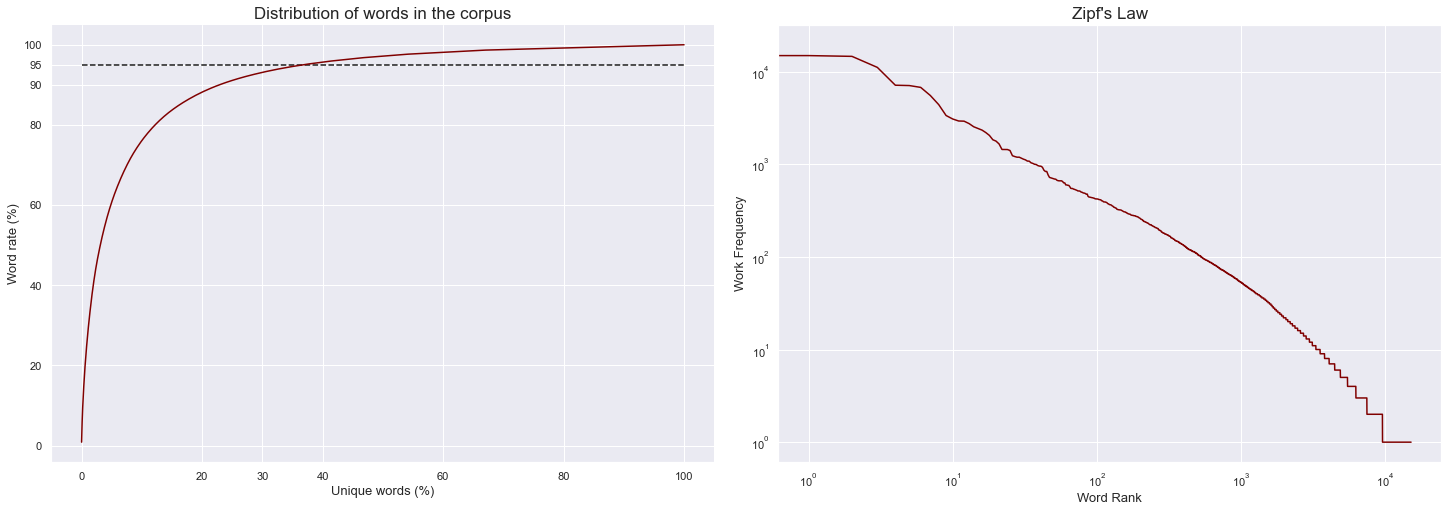

In [78]:
def distrib(cumulative, instances, x=x):
    fig, (ax0, ax1) = plt.subplots(ncols = 2, constrained_layout = True, figsize = (20, 7))

    ax0.plot([0, 100], [95, 95], '--k')
    ax0.set_yticks([0, 20, 40, 60, 80, 90, 95, 100], minor=False)
    ax0.set_xticks([0, 20, 30, 40, 60, 80, 100], minor=False)
    ax0.plot(x, cumulative, color = 'maroon')
    ax0.set_xlabel('Unique words (%)', size = 13)
    ax0.set_ylabel('Word rate (%)', size = 13)
    ax0.set_title('Distribution of words in the corpus', size = 17)

    #removing top and right borders
    ax0.spines['top'].set_visible(False)
    ax0.spines['right'].set_visible(False)


    ax1.set_yticks([0, 20, 40, 60, 80, 90, 95, 100], minor=False)
    x1 = np.arange(0, np.shape(instances)[0], 1)
    ax1.plot(x1, instances["count"].tolist(), color = 'maroon')
    plt.xscale('log')
    plt.yscale('log')
    ax1.set_xlabel('Word Rank', size = 13)
    ax1.set_ylabel('Work Frequency', size = 13)
    ax1.set_title('Zipf\'s Law', size = 17)
    #fig.savefig('Distribution_without_stopwords.pdf')
    plt.show()
    return

distrib(cumulative, instances1)

Les graphiques ci-dessus représentent les 2 indicateurs de distribution évoqués précédemment. A gauche, nous avons la fonction de distribution des mots du corpus. Nous observons que seulement 35% des mots du vocabulaire représentent 95% des mots du corpus. A droite, nous avons une représentation, dans un système de coordonnées log-log, de la fréquence d'un mot du corpus selon son rang dans l'ordre des fréquences. Par exemple, le dixième mot le plus représenté dans le corpus apparaît à 5000 occurrences. La courbe formée par cette représentation n'est pas exactement une droite comme le prévoit la loi de Zipf mais possède un coude caractéristique de la loi de Mandelbrot qui est simplement une généralisation de la loi de Zipf. Selon cette loi, le rang d'un mot est lié à son nombre d'occurrence par la relation : $f(n) \cdot (a+bn)^c = K$ où K est une constante. Cette loi se ramène effectivement à celle de Zipf dans le cas particulier où $a$ vaut 0 et  $b$ et $c$ égaux à 1. Ce cas ne se rencontre pas dans la pratique $c$ étant généralement voisin de 1,1 ou 1,2. 

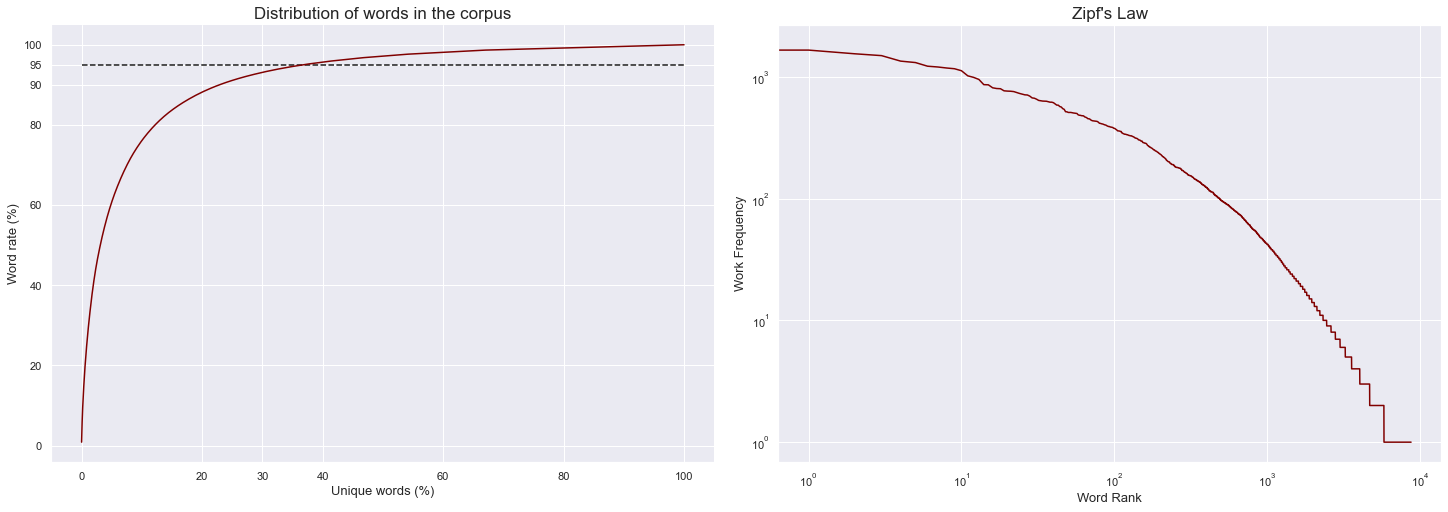

In [79]:
# Observons la distribution des mots du corpus.
cumulative = np.cumsum(instances2["count"].tolist())
cumulative = cumulative/cumulative[-1] * 100
x = np.linspace(0, 100, len(instances2["value"].tolist()))

distrib(cumulative, instances2)

En supprimant les stop-words, nous pouvons voir que la distribution du vocabulaire change légèrement. À présent ce sont 35% des mots du vocabulaire qui représentent 95% des mots du corpus. De plus nous ne retrouvons pas la forme caractéristique de la loi de Zipf ou de Mandelbrot, celle-ci n'est désormais plus vérifiée. 

In [102]:
test = df.copy()

In [103]:
# Nous observons la taille des dictionnaires selon les labels: 1, 2, 3, 4, 5, 6, 7....

taille = []
for i in range(1, 8):
    corpus1 = test[test["category_1"]==i].reset_index(drop = True)
    
    full = corpus1['lem_sent']
        
    text = " ".join(full)
    tokens = tokenizer.tokenize(text)
    #filtered_tokens = [w for w in tokens if not w in stop_words] 
    
    counts,values = pd.Series(tokens).value_counts().values, pd.Series(tokens).value_counts().index
    #counts,values = pd.Series(filtered_tokens).value_counts().values, pd.Series(filtered_tokens).value_counts().index
    instances = pd.DataFrame(list(zip(values,counts)),columns=["value","count"])
    taille.append(np.shape(instances)[0])

In [104]:
print('Taille des dictionaires des différentes catégories: {}'.format(taille))
# Le dictionnaire de la catégorie 1 contient 3434 mots, celui de la catégorie 2 contient 2383 mots...

Taille des dictionaires des différentes catégories: [3434, 2383, 2857, 4434, 5302, 3485, 2495]


In [105]:
# Nous créons des database pour chaque label
data = []
for i in range(1, 8):
    eap = df[df['category_1'] == i]['words'].tolist()
    eap_words = pd.Series(itertools.chain.from_iterable(eap))
    occurences, words = eap_words.value_counts().values, eap_words.value_counts().index

    tmp = pd.DataFrame({"Words" : words, "Occurences" : occurences})
    
    data.append(tmp)

In [106]:
from IPython.display import display_html

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.render()
        
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    l = html_str.replace('table','table style="display:inline"')
    return l

In [107]:
df1 = data[0].head(10).style.set_caption('Label 1') #Words occurences in category 7 texts
df2 = data[1].head(10).style.set_caption('Label 2') #Words occurences in category 7 texts
df3 = data[2].head(10).style.set_caption('Label 3') #Words occurences in category 7 texts
df4 = data[3].head(10).style.set_caption('Label 4') #Words occurences in category 7 texts
df5 = data[4].head(10).style.set_caption('Label 5') #Words occurences in category 7 texts
df6 = data[5].head(10).style.set_caption('Label 6') #Words occurences in category 7 texts
df7 = data[6].head(10).style.set_caption('Label 7') #Words occurences in category 7 texts

In [96]:
# Mots les plus utilisés dans chaque catégorie.
l = display_side_by_side(df1, df2, df3, df4, df5, df6, df7)

,Words,Occurences
0,eu,421
1,european,242
2,uk,231
3,international,185
4,country,175
5,work,174
6,support,162
7,britain,158
8,force,153
9,security,148


En examinant par exemple les 10 mots les plus fréquents de chaque classe, nous remarquons que certains intitulés de catégories peuvent être facilement inférés. Par exemple, les termes *"business", "tax", "economy", "government", "public"* et *"investment"* nous indiquent presque explicitement que la catégorie 4 regroupe les unités de sens évoquant le thème de l'Economie. De même pour la catégorie 5, nous pourrions déduire son thème grâce aux termes les plus représentés. En revanche certaines catégories semblent relativement poreuses entre elles. Par exemple les classes 2 et 7 ont six termes en commun parmi leurs mots les plus fréquents. A priori, il sera difficile pour un algorithme de faire la distinction entre les deux labels.

## Distance entre les dictionnaires

Le problème est que deux phrases traitant du même sujet peuvent utiliser des vocabulaires distincts. Nous aimerions donc trouver une mesure qui nous permette d'évaluer la distance entre les corpus d'unités de sens. La mesure introduite par Kusner et al. en 2015 appelée **Word Mover's Distance** (WMD) permet justement d'évaluer une distance entre deux documents ou deux phrases. Cette mesure est construite pour surmonter le problème des mots synonymes. 

Dans notre cas, les documents sont des corpus de phrases. Pour évaluer la distance entre deux corpus, nous pourrions mesurer pour chaque phrase du premier corpus, sa distance à chaque phrase du second corpus et établir une moyenne. Cette approche est toutefois extrêmement coûteuse computationnellement. Pour tenter de palier à ce problème, nous avons réduit chaque corpus à son dictionnaire et nous mesurons alors la distance entre les dictionnaires deux à deux privés de leur intersection (le coût de transport d'un mot présent dans les deux dictionnaires étant nul). Ainsi pour chaque mot présent dans un dictionnaire, nous calculons sa word mover's distance au second dictionnaire et nous sommons ces distances.

In [8]:
##### Ne pas Run !!!!!!! ######

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors

glove2word2vec(glove_input_file="./glove/glove.6B.50d.txt", word2vec_output_file="gensim_glove_vectors.txt")
glove_model = KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary=False)

In [42]:
# This function compute the Word Mover's DIstance between category's dictionaries. I
# It is extremely expensive computationnaly. 

costs = []
duo = list(itertools.combinations([1, 2, 3, 4, 5, 6, 7], 2))

for place in tqdm(duo):
    dist = 0
    i = place[0]-1
    j = place[1]-1
    l = " ".join(data[i]['Words']).split()
    m = " ".join(data[j]['Words']).split()
    inter = [value for value in l if value in m] 
    
    new1 = [value for value in l if value not in inter] 
    new2 = [value for value in m if value not in inter] 
    
    for word in new1:
        dist += glove_model.wmdistance(word, new2)
    costs.append(dist)

In [53]:
cost = [11393.782750933718, 9796.469827061355, 7421.105262534247, 6376.423378134126, 8545.480370922724,10987.519609021147,
         5336.166709065291, 4404.493310510671, 3474.846449102434, 4465.130681843044, 6575.654370894078, 4539.095490651731,
         3876.0230244410095, 5943.910756903781, 8098.479874850679, 8191.65120136847, 13347.94109663537, 15751.036365638785,
         17158.099337288077, 20427.37180711111, 11241.325857952794]

In [47]:
distances = np.array([[0, cost[0], cost[1], cost[2], cost[3], cost[4], cost[5]], 
                     [cost[0], 0, cost[6], cost[7], cost[8], cost[9], cost[10]], 
                     [cost[1], cost[6], 0, cost[11], cost[12], cost[13], cost[14]], 
                     [cost[2], cost[7], cost[11], 0, cost[15], cost[16], cost[17]], 
                     [cost[3], cost[8], cost[12], cost[15], 0, cost[18], cost[19]], 
                     [cost[4], cost[9], cost[13], cost[16], cost[18], 0, cost[20]], 
                     [cost[5], cost[10], cost[14], cost[17], cost[19], cost[20], 0]])

In [50]:
table = np.array([distances[0], distances[1], distances[2], distances[3], distances[4], distances[5], distances[6]])
index = ['1', '2', '3', '4', '5', '6', '7']
cols = ['1', '2', '3', '4', '5', '6', '7']

 Nous obtenons les résultats suivant: 

In [51]:
# Word Mover Distance entre les classes.

with pd.option_context('display.precision', 2):
    cm = sns.light_palette("green", as_cmap=True)
    d = pd.DataFrame(table, index = index, columns = cols)
    s = d.style.background_gradient(cmap=cm)
    
s.background_gradient(cmap="RdYlGn", axis = None, low = 0)

,1,2,3,4,5,6,7
1,0.00,11393.78,9796.47,7421.11,6376.42,8545.48,10987.52
2,11393.78,0.00,5336.17,4404.49,3474.85,4465.13,6575.65
3,9796.47,5336.17,0.00,4539.10,3876.02,5943.91,8098.48
4,7421.11,4404.49,4539.10,0.00,8191.65,13347.94,15751.04
5,6376.42,3474.85,3876.02,8191.65,0.00,17158.10,20427.37
6,8545.48,4465.13,5943.91,13347.94,17158.10,0.00,11241.33
7,10987.52,6575.65,8098.48,15751.04,20427.37,11241.33,0.00


Tout d'abord nous précisons que plus la distance entre deux dictionnaires est petite, plus la couleur tend vers le rouge; a contrario, plus la distance est élevée, plus la couleur tend vers le vert. La diagonale de zéros est donc naturelle, la distance entre deux dictionnaires identiques étant nulle. Nous observons sur ce tableau que les dictionnaires des classes 2 et 3 sont particulièrement proches des dictionnaires des classes 2 à 7. Par conséquent, il sera sans doute particulièrement difficile pour des modèles d'apprentissage de distinguer ces deux labels des autres catégories. Nous pouvons supposer que ces classes risquent de profondément dégrader la qualité des prédictions des modèles testés. D'autre part, malgré le fait que les catégories 4 et 5 soient les plus représentées dans la base et aient par conséquent un vocabulaire plus fourni, leurs dictionnaires semblent relativement éloignés de ceux des autres classes (hormis ceux des catégories 1 et 2). Cela nous laisse donc présager que nous aurons de bons résultats d'apprentissage sur ces catégories 4 et 5.

In [50]:
#df.to_pickle("clean_data.pkl") 

## Classification Manuelle

Avant de nous plonger dans l'implémentation de modèles, nous décidons de tenter de classifier nous même quelques échantillons de la base de données pour évaluer la complexité de la tâche. Cela constitue une étape importante de notre démarche de recherche car nous nous rendons compte qu'il ne s'agit pas d'un processus trivial. Nous émettons donc plusieurs hypothèses. Tout d'abord il est difficile d'identifier le thème de certaines phrases hors de leur contexte. La classification des codeurs du *Manifesto Project* a été effectuée discours par discours, et de fait, ils disposaient du contexte de la totalité du discours pour appuyer leurs choix. Ainsi, sans contexte, le thème de certaines unités de sens n'est pas évident à déterminer. Par exemple nous pourrions ranger la phrase *'Is my job secure ?'* dans la classe **Économie** dans la mesure où l'emploi et le chômage sont des sujets relatifs à cette thématique. Il s'avère que cette phrase appartient à la classe **Groupe sociaux**. Ce point est directement lié au fait que  certaines classes nous semblent proches, et que celles-ci peuvent traiter de sujets qui ne sont pas entièrement incompatibles. Pour illustrer cette observation, prenons l'exemple de la phrase *'to promote equality in relationships and for LGBT individuals we will'*. Nous estimons que cette phrase, aurait très bien pu être rangée dans la catégorie *Liberté et Démocratie* alors qu'elle appartient à la classe *Bien être et qualité de vie*. Un dernier exemple est la phrase *'But stability is not enough'* qui sans information supplémentaire, peut appartenir aux quatre premières catégories. 

In [4]:
df = pd.read_pickle('clean_data.pkl')

# Modèles de Machine Learning
## Benchmark de modèles

In [5]:
GLOVE_6B_50D_PATH = "./glove/glove.6B.50d.txt"
encoding="utf-8"

In [6]:
import gensim 
from tabulate import tabulate
from gensim.models.word2vec import Word2Vec
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, GridSearchCV

from nltk.stem.porter import *
import nltk

In [590]:
X, y = np.array(df['words']), np.array(df['category_1'])

Les données textuelles dont nous disposons sont difficilement exploitables par des algorithmes d'apprentissage. Nous devons alors trouver des méthodes permettant de les représenter sous forme numérique propice à l'apprentissage statistique. Nous nous sommes d'abord penchés sur des modèles simples qui représentent une phrase par un vecteur où les entrées correspondent à la présence, la fréquence ou le poids d'un mot. Puis nous nous sommes intéressés à des modèles de Word Embedding. En Natural Language Processing, le **word embedding** désigne un ensemble de techniques visant à représenter les mots ou phrases d'un texte sous la forme de vecteurs de nombres réels, décrits dans un modèle vectoriel. Ces représentations de données textuelles permettent d’améliorer les performances de méthodes de Natural Language Processing. Un mot est caractérisé par son contexte, c’est à dire par les mots qui l’entourent. Ainsi, des mots partageant des contextes similaires partagent également des significations similaires. Les algorithmes de word embedding sont le plus souvent employés pour décrire des mots à travers des vecteurs numériques, mais ils peuvent également être utilisés pour construire des représentations vectorielles de phrases entières. Les premières approches du word embedding remontent aux années 1960 et reposent sur des méthodes de réduction de dimensions. Plus récemment, de nouvelles techniques basées sur des modèles probabilistes et des réseaux de neurones, comme Word2Vec, permettent d’obtenir de meilleures performances. Dans le cadre de notre projet, nous voulons utiliser différentes méthodes de représentation des phrases afin de comparer leurs performances sur plusieurs modèles d'apprentissage. Nous avons sélectionné d'une part des modèles simples de représentations vectorielles tels que le Bag-of-Words (BoW) ou Term Frequency - Inverse Term Frequency (TF-IDF) mais aussi des modèles de word embedding plus complexes telles que Word2Vec, GloVe ou Universal Sentence Encoder. 

In [7]:
# Nous utilisons les embeddings de GloVe 
import struct 

glove_small = {}
all_words = set(w for words in X for w in words)

with open(GLOVE_6B_50D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if (word in all_words):
            nums=np.array(parts[1:], dtype=np.float32)
            glove_small[word] = nums

In [9]:
# Nous entrainons le modèle Word2Vec sur notre corpus de phrases. 
model = Word2Vec(X, size=100, window=5, min_count=5, workers=2)
w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  after removing the cwd from sys.path.


Maintenant que nous pouvons représenter les unités de sens sous forme de vecteurs, il nous faut entraîner des algorithmes d'apprentissage statistique afin de leur attribuer automatiquement un label. Notre objectif est alors de labelliser au mieux les phrases du corpus, c'est à dire nous cherchons une méthode d'apprentissage qui commette le moins d'erreurs possible sur l'attribution des catégories vis à vis de celle de l'équipe de codeurs. Pour ce faire, nous devons comparer la performance de différents algorithmes d'apprentissage qui prennent en entrée les différents types de représentation précédemment évoqués. Pour effectuer une telle comparaison nous entraînons des algorithmes classiques de machine learning permettant réaliser de la classification. Nous utilisons ainsi un classifieur naïf bayésien basé sur des variables de bernoulli multivariées, un classifieur naïf bayésien basé sur des variables multinomiales, un Support Vector Machine (SVM) ainsi que des Extremely Randomized Trees.

In [191]:

# start with the classics - naive bayes of the multinomial and bernoulli varieties
# with either pure counts or tfidf features
mult_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
bern_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x, binary = True)), ("bernoulli nb", BernoulliNB())])
#mult_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
#bern_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])
# SVM - which is supposed to be more or less state of the art 
svc = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear"))])
svc_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear"))])

In [11]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_small))])
        else:
            self.dim=0
            
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

    
# and a tf-idf version of the same
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_small))])
        else:
            self.dim=0
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])
 

In [12]:
etree_glove_small = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators = 200))])
etree_glove_small_tfidf = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators = 200))])

etree_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators = 200))])
etree_w2v_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators = 200))])

In [ ]:
from sklearn.model_selection import StratifiedKFold
all_models = [
    ("Mult NB", mult_nb),
    ("Bern NB", bern_nb),
    ("SVC", svc),
    ("SVC TF-IDF", svc_tfidf),
    ("XTrees W2V", etree_w2v),
    ("XTrees W2V TF-IDF", etree_w2v_tfidf),
    ("XTrees Glove", etree_glove_small),
    ("XTrees Glove TF-IDF", etree_glove_small_tfidf)
]


def scoring(model, score):
    evaluation = cross_val_score(model, X, y, cv=StratifiedKFold(n_splits = 3, shuffle = True), scoring = score).mean()
    return evaluation

unsorted_scores = [(name, scoring(model, score = 'accuracy'), scoring(model, score = "recall_weighted"), scoring(model, score = "precision_weighted"), 
                   scoring(model, score = "f1_weighted")) for name, model in all_models]


In [205]:
scores = np.asarray(sorted(unsorted_scores, key=lambda x: -x[1])).T
#scores = np.asarray(unsorted_scores).T
names = scores[0].copy()
new_score = np.array(scores[1:].copy(), dtype = np.float32)

In [206]:
table = np.array([new_score[0], new_score[1], new_score[2], new_score[3]]).T
index = ["SVC TF-IDF", "Mult NB", "Bern NB", 'SVC', "XTrees Glove", "XTrees Glove TF-IDF", "XTrees W2V TF-IDF", "XTrees W2V"]
cols = ['Accuracy', 'Recall', 'Precision', 'F1-Score']



In [207]:
#import seaborn as sns
with pd.option_context('display.precision', 3):
    cm = sns.light_palette("green", as_cmap=True)
    d = pd.DataFrame(table, index = index, columns = cols)
    s = d.style.background_gradient(cmap=cm)
    
s

,Accuracy,Recall,Precision,F1-Score
SVC TF-IDF,0.628,0.630,0.627,0.624
Mult NB,0.619,0.617,0.612,0.605
Bern NB,0.591,0.594,0.592,0.586
SVC,0.586,0.583,0.596,0.559
XTrees Glove,0.536,0.534,0.564,0.494
XTrees Glove TF-IDF,0.531,0.530,0.560,0.486
XTrees W2V TF-IDF,0.475,0.478,0.462,0.447
XTrees W2V,0.468,0.469,0.460,0.441


Le tableau présenté ci-dessous répertorie les différents scores de classification obtenus par les algorithmes évoqués et entraînés sur différents types d'embeddings. Les résultats sont des scores moyens obtenus par *3-fold cross-validation*. Cela signifie que la base de données a été séparée en 3 sous-échantillons et chaque algorithme s'est entrainé sur deux d'entre eux et a calculé ses scores de performance sur le troisième. Ce processus est réitéré 2 fois en changeant le sous-échantillon de validation. Chaque score répertorié est alors une moyenne des scores obtenus pour les 3 cross-validation. 

Précisons que le score *accuracy* correspond au rapport du nombre de labels correctement prédits par le modèle sur le nombre d'observations. Ce score d'*accuracy* permet d'évaluer la performance "brute" d'un modèle. Toutefois, cette métrique n'est plus pertinente dans le cas où le nombre d'observations par catégorie est très déséquilibré. En effet, un classifieur prédisant uniquement la classe la plus représentée peut avoir un bon score d'*accuracy* alors qu'il n'effectue aucun travail de classification. Deux autres métriques permettent de mesurer la précision effective d'un modèle: le **recall** et la **precision**. Ces métriques sont définies de la manière suivante:

\begin{align}
    Recall &= \dfrac{\scriptstyle{True\ \ Positive}}{\scriptstyle{True\ \ Positive\ \ +\ \ False\ \ Negative}}
\end{align}

\begin{align}
    Precision &= \dfrac{\scriptstyle{True\ \ Positive}}{\scriptstyle{True\ \ Positive\ \ +\ \ False\ \ Positive}}
\end{align}

Lorsque ces scores sont proches de 1, le modèle prédit peu de faux négatifs en proportion dans le cas du **recall** et peu de faux positifs en porportion dans le cas de la **precision**. Par conséquent, des scores proches de 1 signifient que le modèle effectue une classification de qualité. Le **F1-score** est quant à lui un score qui pondère le **recall** et la **precision**.

\begin{align}
    F_1 &= 2 \cdot \dfrac{\scriptstyle{precision \ \ \times \ \ recall} }{\scriptstyle{precision \ \ + \ \ recall}}
\end{align}

Le meilleur algorithme en terme d'**accuracy** est le *Support Vector Classifier* entraîné par dessus un TF-IDF. Ses scores d'**accuracy** ainsi que de **recall** sont de l'ordre de 0.63 et le score de **precision** est de 0.627. Les modèles suivants présentant les meilleurs performances sont les classifieurs naïfs bayésiens fondés sur des variables multinomiales (Bag-of-Words qui tient compte de la fréquence d'un mot) et sur des variables de Bernoulli multivariées (Bag-of-Words qui tient compte uniquement de la présence d'un mot). Les scores pour ces modèles sont proches: une **accuracy** de 0.619 pour le premier, 0.591 pour le second; un **recall** de 0.617 pour le premier et de 0.594 pour le second; une **precision** de 0.612 pour le premier et de 0.592 pour le second. Par ailleurs, les scores des *Extremly Randomized Trees* sont relativement décevants car bien en dessous des résultats évoqués précédemment, et ce quel que soit le type d'embedding utilisé. Par exemple, l'*Extra Trees Classifier* entraîné par dessus les embeddings de GloVe ne présente qu'un score d'accuracy de 0.536 et un **recall** et **precision** du même ordre de grandeur. Le moins bon score d'**accuracy** est de 0.468, obtenu avec un *Extras Trees Classifier* entraîné par dessus les embeddings de Word2Vec. 

## L'exemple du Support Vector Classifier

De manière générale, les résultats de ces modèles sont très hétérogènes. Les scores des modèles les moins performants sont décevants dans la mesure où ils ne sont pas même proches d'un niveau qui puisse permettre d'automatiser la labellisation des unités de sens. Ils performent certes mieux qu'une attribution aléatoire des labels (qui donne en moyenne une **accuracy** d'environ 14%) mais restent loin d'une classification satisfaisante. Néanmoins, les résultats du *Support Vector Classifier* entraîné avec la représentation d'un TF-IDF sont honorables et nous laissent optimistes pour la suite. L'analyse de ses erreurs nous intéresse particulièrement afin d'évaluer en détail la qualité de sa classification.

In [591]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42, stratify = y)

In [ ]:
from sklearn.metrics import confusion_matrix
svc_tfidf.fit(X_train, y_train);
y_pred = svc_tfidf.predict(X_test);

In [363]:
def conf_matrix(y_true, y_pred, title):
    C = confusion_matrix(y_true, y_pred)
        
    ConfMatrix = C / C.sum(axis=1)[:,None]
        
    plt.figure(figsize = (10, 5))
    ax = sns.heatmap(ConfMatrix, annot=True, cmap="Reds", fmt=".2f",
                xticklabels = ['1', '2', '3', '4', '5', '6', '7'], 
                yticklabels = ['1', '2', '3', '4', '5', '6', '7'])
    
    sns.set()

    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom, top)

    plt.xlabel('Predicted Class', fontsize = 12)
    plt.ylabel('True Class', fontsize = 12)
    #plt.title("Confusion Matrix", size = 14)
    plt.savefig(title+".pdf")
    
    return plt.show()

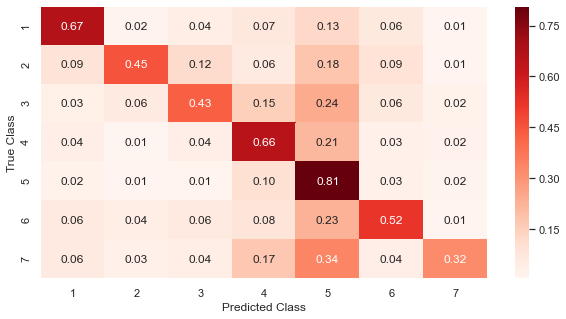

In [197]:
conf_matrix(y_test, y_pred)
#plt.savefig("conf_matrix_svc.pdf")

La matrice de confusion présentée ci-dessus, correspond aux résultats obtenus par le *Support Vector Classifier* normalisés par le nombre d'observations dans chaque catégorie. Ainsi les scores présents sur la diagonale représentent les scores de **recall** pour chaque catégorie. Nous remarquons tout d'abord que la qualité de la prédiction selon les labels est très disparate. Comme nous nous y attendions, la classe 5 qui est la plus représentée dans la base de donnée est la mieux prédite par le modèle avec 81% des labels de ses unités de sens correctement attribués. Nous notons toutefois que 10% de ses labels sont attribués à tort à la classe numéro 4. De manière générale, nous observons que pour chaque catégorie, une proportion non négligeable de labels sont attribués à cette catégorie 5. La seconde catégorie dont les labels sont les mieux attribués est la catégorie 1 avec 67% d'unités de sens correctement classifiées. Ici aussi une proportion non négligeable (13%) des labels de cette classe sont attribués à tort à la classe 5. Ces résultats sont à peu près similaires à ceux de la catégorie 4 alors que le nombre d'observations de celle-ci est bien supérieur. De plus le modèle confond davantage les catégories 4 et 5, 20% des unités de sens de la classe 4 sont étiquetées comme appartenant à la classe 5. Concernant la catégorie 2, 45% de ses phrases sont correctement étiquetées, mais respectivement 12%, 18% et 9% des unités de sens de cette catégorie sont attribuées à tort aux classes 3, 5 et 6. Par ailleurs le modèle commet beaucoup d'erreurs sur la labellisation des unités de sens de la catégorie 3 dont seulement 45% sont correctement labellisées. Le modèle confond cette classe principalement avec les catégories 4 et 5. Finalement la catégorie dont le pourcentage d'étiquetage corrects est la plus faible est la catégorie 7 dont seulement 32% des unités de sens sont bien étiquetées. Un résultat surprenant apparaît ici, 34% des phrases de cette catégorie 7 sont attribués à tort à la catégorie 5 alors même que nous avions observé précédemment que leurs dictionnaires étaient les plus éloignés. Ce résultat nous dévoile sans doute les limites de l'approche de comparaison des distances entre les dictionnaires que nous avons adoptée précédemment.

Un second outil nous permettant d'apprécier la qualité des prédictions du modèle est le *classification report*:

In [195]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.67      0.67      0.67       471
           2       0.61      0.45      0.52       269
           3       0.53      0.43      0.48       390
           4       0.64      0.66      0.65       964
           5       0.65      0.81      0.72      1449
           6       0.61      0.52      0.56       482
           7       0.60      0.32      0.42       307

    accuracy                           0.64      4332
   macro avg       0.62      0.55      0.57      4332
weighted avg       0.63      0.64      0.63      4332



 Ce tableau regroupe les scores de **precision**, **recall** et **F1-score** de chaque catégorie. Conformément à la normalisation effectuée sur la matrice de confusion, nous retrouvons bien les mêmes scores de **recall**. Nous notons que pour la plupart des catégories, les scores de **precision** et **recall** sont assez différents. Par exemple pour la catégorie 2, le score de **precision** est supérieur de 16 points de pourcentage au score de de **recall**. Cela signifie que pour cette catégorie, le modèle possède une précision que nous qualifions de moyenne (61%) mais est assez peu sensible puisqu'il n'a trouvé que 45% des labels possibles pour cette catégorie. Ceci est particulièrement vrai pour la catégorie 7 où l'écart entre ces deux scores est le plus important (32 points de pourcentage). En revanche, l'inverse se produit concernant la catégorie 5, où le modèle possède un très bon score de **recall** (81%) mais sa précision de 65% indique qu'il fournit de nombreux labels erronés en plus de ceux correctement attribués. 

## Aproche $n$-grams

Dans l'approche que nous avons adoptée jusqu'alors, les mots qui constituent une unité de sens sont transformés en vecteurs afin de pouvoir implémenter des modèles d'apprentissage. La limite principale de cette démarche est la perte de contexte des mots d'une phrase. En effet, l'ordre des mots dans une phrase contribue à son sens et, de fait, chacun d'entre eux s'appuie sur ses voisins afin de former un tout cohérent. Nous n'avons absolument pas tenu compte de cette dimension dans les modèles précédemment implémentés, et nous soupçonnons que cela pèse sur les performances. Par conséquent nous décidons de ré-entraîner le *Support Vector Classifier* sur les embeddings du TF-IDF en utilisant des **n-grams**, qui sont des sous-séquences de $n$ éléments construites à partir d'une séquence donnée. Nous ne détaillons pas en détail la théorie derrière ce procédé mais son utilisation nous permet de considérer chaque mot d'une phrase selon ses voisins. Dans cette nouvelle implémentation du *Support Vector Classifier*, nous considérons pour chaque mot ses quatre voisins (s'ils existent).

In [187]:
svc_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: everygrams(x, 1, 5))), ("linear svc", SVC(kernel="linear"))])

In [188]:
svc_tfidf.fit(X_train, y_train);
y_pred_grams = svc_tfidf.predict(X_test);

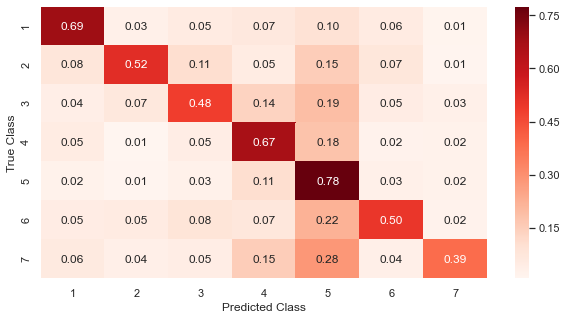

In [199]:
conf_matrix(y_test, y_pred_grams)

Nous remarquons que la plupart des résultats présents sur la diagonale ont légèrement augmenté. Cette augmentation est marginale pour certaines catégories telles que la 1 ou la 4 dont les scores de **recall** augmentent respectivement de 2 et 1 points de pourcentage. Les scores des catégories 2, 3 et 7 en revanche ont augmenté notablement avec respectivement 7 points de pourcentage supplémentaires pour le **recall** de la classe 2, 5 pour la classe 3 et 7 pour la classe 7. Finalement, seules les catégories 5 et 6 voient leurs scores légèrement diminuer de 2 à 3 points de pourcentage. 

In [190]:
print(classification_report(y_test, y_pred_grams))

              precision    recall  f1-score   support

           1       0.67      0.69      0.68       471
           2       0.59      0.52      0.55       269
           3       0.50      0.48      0.49       390
           4       0.66      0.67      0.66       964
           5       0.68      0.78      0.72      1449
           6       0.63      0.50      0.56       482
           7       0.57      0.39      0.46       307

    accuracy                           0.64      4332
   macro avg       0.61      0.58      0.59      4332
weighted avg       0.64      0.64      0.64      4332



Nous observons néanmoins sur le classification report que les scores de **precision** ont légèrement diminué en moyenne. Toutefois, ces baisses sont plus modérées que la hausse des score de **recall** ce qui nous permet d'obtenir des **F1-score** plus élevés pour l'ensemble des catégories. L'évolution de ces scores est certes marginale mais cela souligne globalement une très légère amélioration de la qualité de la prédiction. L'**accuracy** quant à elle est restée inchangée avec un score de 64%.

Finalement, nous nous demandons si le nombre de données dont nous disposons est suffisant pour obtenir des résultats satisfaisants. En comparant les différents modèles, nous avons effectué des *3-fold cross validation* ce qui signifie que chaque algorithme s'est entraîné sur deux-tiers de la base. En produisant les résultats du *Support Vector Classifier*, nous avons considéré 80% de la base comme données d'apprentissage. Nous voulons alors déterminer l'évolution du score d'*accuracy* selon le nombre de données d'apprentissage. 

In [258]:
train, test, label_train, label_test = train_test_split(M, labels, train_size = 0.8, random_state = 42, stratify = y)

In [203]:
def benchmark(model, X, y, n):
    test_size = 1 - (n / float(len(y)))
    scores = []
    sss = StratifiedShuffleSplit(n_splits=3, test_size=test_size)
    for train, test in sss.split(X, y):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        scores.append(accuracy_score(model.fit(X_train, y_train).predict(X_test), y_test))
    return np.mean(scores)

In [206]:
models = [
    ("Mult NB", mult_nb),
    ("Bern NB", bern_nb),
    ("SVC TF-IDF", svc_tfidf),
    ("SVC", svc),
    ("XTrees W2V TF-IDF", etree_w2v_tfidf),
    ("XTrees Glove", etree_glove_small)]

In [211]:
train_sizes = [10, 160, 640, 3200, 6400, 10000, 15000]
table = []
for name, model in models:
    for n in train_sizes:
        table.append({'model': name, 
                      'accuracy': benchmark(model, X, y, n), 
                      'train_size': n})
df = pd.DataFrame(table)

Text(0.5, 0, 'Labeled training examples')

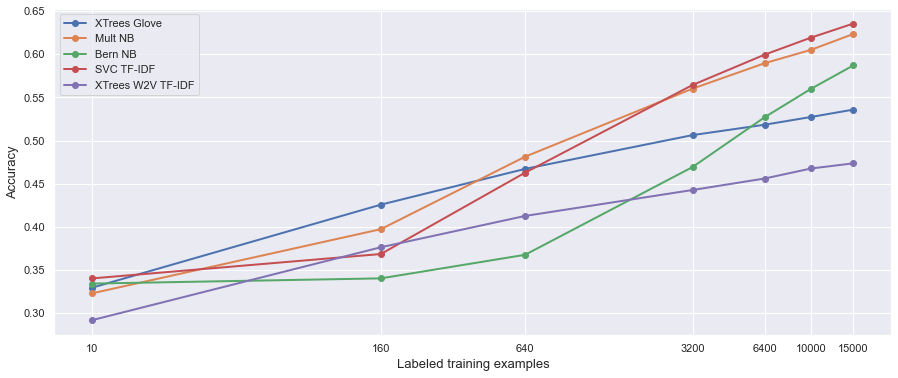

In [213]:
data = df[df.model.map(lambda x: x in ["Mult NB", "Bern NB", "SVC TF-IDF", "SVC", "XTrees W2V TF-IDF", "XTrees Glove"])]

data_glove = data[data['model'] == "XTrees Glove"]
data_mult_nb = data[data['model'] == "Mult NB"]
data_bern_nb = data[data['model'] == "Bern NB"]
svc_tfidf = data[data['model'] == "SVC TF-IDF"]
w2v_tfidf = data[data['model'] == "XTrees W2V TF-IDF"]

sns.set()

fig, ax = plt.subplots(figsize = (15, 6))
ax.plot(data_glove['train_size'], data_glove['accuracy'], 'o-', linewidth = 2, label = "XTrees Glove")
ax.plot(data_mult_nb['train_size'], data_mult_nb['accuracy'], 'o-', linewidth = 2, label = "Mult NB")
ax.plot(data_bern_nb['train_size'], data_bern_nb['accuracy'], 'o-', linewidth = 2, label = "Bern NB")
ax.plot(svc_tfidf['train_size'], svc_tfidf['accuracy'], 'o-', linewidth = 2, label = "SVC TF-IDF")
ax.plot(w2v_tfidf['train_size'], w2v_tfidf['accuracy'], 'o-', linewidth = 2, label = "XTrees W2V TF-IDF")

plt.legend()
ax.set_xscale('log')
ax.set_xticks([10, 160, 640, 3200, 6400, 10000, 15000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

#sns.set_context("notebook", font_scale=1.5)
plt.ylabel("Accuracy", size = 13)
plt.xlabel("Labeled training examples", size = 13)
#plt.title("Models training benchmark", size = 17);
#fig.savefig('Training_models.pdf')

D'après l'allure de ces courbes, l'**accuracy** des algorithmes selon le nombre de données d'apprentissage croit à taux à peu près constant jusqu'au maximum du nombre de labels appris. Nous supposons alors que pour augmenter sensiblement les résultats de classification des modèles, il nous faudrait davantage de données. 

# Modèles d'apprentissage profond
## Réseaux Long Short Term Memory (LSTM)

Les résultats du *Support Vector Classifier* étant prometteurs, nous pensons que nous pourrions améliorer le processus de classification en implémentant des modèles d'apprentissage profond, plus complexes. Les réseaux de neurones récurrents où **RNN** sont un type de réseaux de neurones particulièrement adaptés aux tâches de  Natural Language Processing. A la différence d'un réseau de neurones standard, l'entrée d'un RNN est un unique mot au lieu d'un échantillon entier. Cela permet au réseau de fonctionner avec des longueurs de phrases variables, ce qui ne peut pas être réalisé dans un réseau de neurones standard. Il offre également un avantage supplémentaire de partager des caractéristiques apprises sur différentes positions dans le texte qui ne pourraient pas être obtenues dans un réseau neuronal standard. Un RNN traite chaque mot d'une phrase comme une entrée distincte se produisant à un instant $t$ et utilise en plus de cette entrée, la valeur d'activation en $t-1$. Ce type de réseau connaît néanmoins certaines limites:


1. Tel que nous l'avons présenté, les réseaux de neurones récurrents ne sont capables de capturer les dépendances du langage dans une seule direction. Dans le cas du traitement du langage naturel, il suppose que le mot suivant n'a aucun effet sur le sens du mot précédent, ce qui n'est évidemment pas vrai.
    
2. Aussi, les RNN ne sont pas non plus très performants pour capturer les dépendances à long terme et le problème du **vanishing gradient** refait surface dans les RNN.

Sans nous étendre davantage, nous choisissons d'utiliser des réseaux de neurones **Long Short Term Memory bidirectionnels** (Bidirectional LSTM) qui permettent de palier aux problèmes évoqués. De la même manière que pour la comparaison des algorithmes classiques de machine learning, nous entraînons notre réseau sur plusieurs embeddings. Les résultats des embeddings de Word2Vec étant les plus pertinents, ce sont les seuls que nous présentons. Nous mettons en annexe les graphiques d'apprentissage sur les autres embeddings. 

## LSTM et Word2Vec

In [7]:
df = pd.read_pickle('clean_data.pkl')

In [8]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", DeprecationWarning)
    
    from keras.preprocessing.text import Tokenizer
    from keras.preprocessing.sequence import pad_sequences
    
    from keras.models import Sequential, Model
    from keras.layers import Dense, Dropout, Input, LSTM, Embedding, Bidirectional, Flatten, GRU, concatenate
    from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D, Conv2D
    from keras.optimizers import Adam, SGD

In [9]:
from gensim.models.word2vec import Word2Vec

text_dim = 200

print("Training Word2Vec model...")

wordvec_model = Word2Vec(list((df['words'])), size=text_dim, window=10, min_count=1, workers=4, sg=1)

#size : The number of dimensions of the embeddings and the default is 100.
#window: The maximum distance between a target word and words around the target word. The default window is 5.
#min_count: The minimum count of words to consider when training the model; words with occurrence less than this count will be ignored. The default for min_count is 5.
#workers: The number of partitions during training and the default workers is 3.
#sg: The training algorithm, either CBOW(0) or skip gram(1). The default training algorithm is CBOW.

print("Word2Vec model created.")
print("%d unique words represented by %d dimensional vectors" % (len(wordvec_model.wv.vocab), text_dim))

Training Word2Vec model...
Word2Vec model created.
8751 unique words represented by 200 dimensional vectors


In [10]:
word = ['economic']
similar = [word[0] for word in wordvec_model.wv.most_similar(positive=word)]
similar.extend(word)

print('The most similar words to \"economic\" are: {}'.format(similar))

The most similar words to "economic" are: ['growth', 'stability', 'prosperity', 'stable', 'objective', 'sustainable', 'productive', 'depends', 'longterm', 'whole', 'economic']


In [11]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", DeprecationWarning)
    X = np.zeros((200, len(similar)))
    i = 0
    names = similar.copy()
    for word in similar:
        X[0:,i] = wordvec_model[word]
        i +=1

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


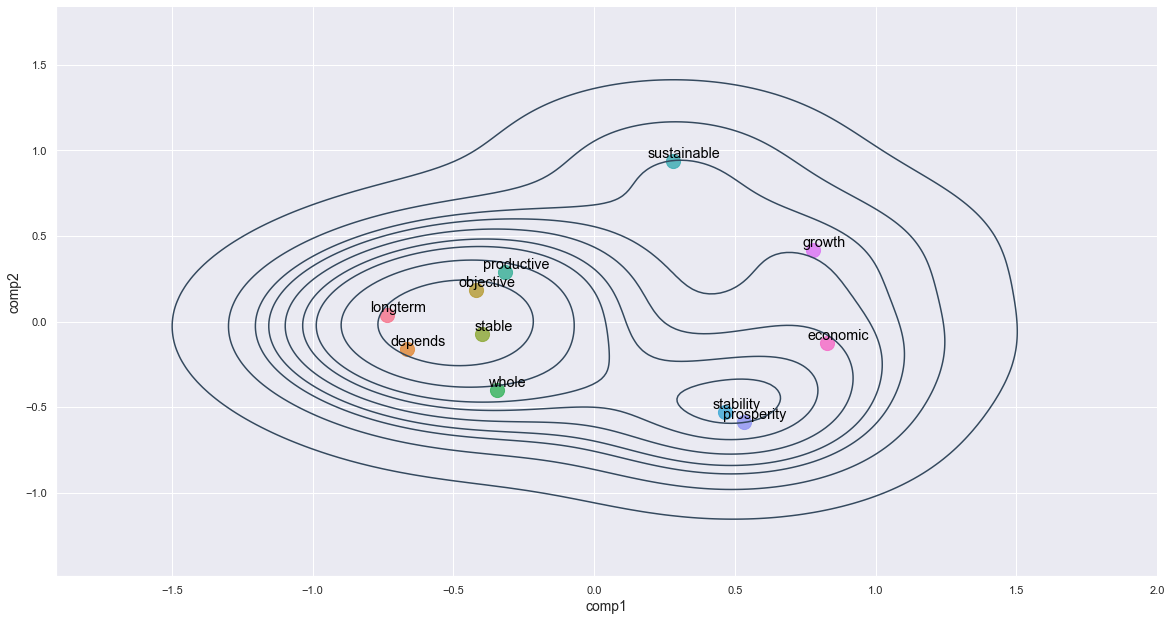

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
temp = pd.DataFrame(pca.fit_transform(X.T),columns = ["comp1", "comp2"])
temp["Name"] = names

g = sns.lmplot(x = "comp1", y = "comp2", hue = 'comp1', data = temp, fit_reg = False, legend = False,
           scatter_kws = {"s":200});

g.fig.set_figheight(10/1.1)
g.fig.set_figwidth(20/1.1)
plt.xlabel('comp1', fontsize=14)
plt.ylabel('comp2', fontsize=14)
#plt.grid(ls = 'dashed')
plt.autoscale(enable=True, axis='both', tight=None)

for line in range(len(similar)):
     plt.text(temp.comp1[line]+0.04, temp.comp2[line]+0.001, s=temp["Name"][line], horizontalalignment='center', verticalalignment='bottom',size='large', color='black', weight='light')
sns.kdeplot(temp["comp1"], temp["comp2"], color = "#34495e");


In [131]:
# save model in ASCII (word2vec) format
filename = 'embedding_word2vec.txt'
model = wordvec_model
model.wv.save_word2vec_format(filename, binary=False)

In [24]:
# load embedding as a dict
def load_embedding(filename):
	# load embedding into memory, skip first line
	file = open(filename,'r')
	lines = file.readlines()[1:]
	file.close()
	# create a map of words to vectors
	embedding = dict()
	for line in lines:
		parts = line.split()
		# key is string word, value is numpy array for vector
		embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
	return embedding

In [32]:
from sklearn.preprocessing import label_binarize

# Transform labels into one hot encoded format.
y_bin = label_binarize(df['category_1'], classes=[1, 2, 3, 4, 5, 6, 7])

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(list(df["words"]), y_bin, test_size=0.2, random_state=42)

In [34]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import nltk
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer

class transformer_data_deep(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, df):
        encoded_docs = self.t.texts_to_sequences(np.array(df))
        #max_length = max([len(s) for s in encoded_docs])
        max_length = 60
        return pad_sequences(encoded_docs, maxlen= max_length, padding='post')

    def fit(self, df_train, y=None):
        self.t = Tokenizer()
        self.t.fit_on_texts(np.array(df_train))
        return self
    
        # create a weight matrix for the Embedding layer from a loaded embedding
    def get_weight_matrix(self, embedding):
        vocab = self.t.word_index
        # total vocabulary size plus 0 for unknown words
        vocab_size = len(vocab) + 1
        # define weight matrix dimensions with all 0
        weight_matrix = np.zeros((vocab_size, 200))
        # step vocab, store vectors using the Tokenizer's integer mapping
        for word, i in vocab.items():
            weight_matrix[i] = embedding.get(word)
        return weight_matrix, vocab_size

In [39]:
transform = transformer_data_deep()
transform.fit(X_train)
X_train_input = transform.transform(X_train)
X_test_input = transform.transform(X_test)

ipykernel_launcher:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
ipykernel_launcher:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [137]:
# load embedding from file
raw_embedding_w2v = load_embedding('embedding_word2vec.txt')

In [325]:
kernel_size = 5
pool_size = 4
maxlen = 60

def build_model(raw_embedding):

    embedding_dim = 100
    inp = Input(shape=(maxlen, ))
    
    # get vectors in the right order
    embedding_vectors, vocab_size = transform.get_weight_matrix(raw_embedding)
       
    x = Embedding(vocab_size, 200, weights=[embedding_vectors], input_length=60, trainable=False)(inp)
    x = SpatialDropout1D(0.1)(x)
    
    x = Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.1, return_sequences=True))(x)
    x = Conv1D(filters = 64,
                 kernel_size = 5,
                 padding='valid',
                 activation='elu',
                 strides=1, kernel_initializer = "glorot_uniform")(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool]) 
    preds = Dense(7, activation="softmax")(conc)
    
    model = Model(inputs = inp, outputs = preds)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [326]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", DeprecationWarning)
    model = build_model(raw_embedding_w2v)  #('mlp')
    model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 60)           0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 60, 200)      1621200     input_11[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_11 (SpatialDr (None, 60, 200)      0           embedding_11[0][0]               
__________________________________________________________________________________________________
bidirectional_11 (Bidirectional (None, 60, 128)      135680      spatial_dropout1d_11[0][0]       
____________________________________________________________________________________________

In [43]:
from keras.callbacks import ModelCheckpoint

In [327]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", DeprecationWarning)
    
    model = build_model(raw_embedding_w2v)
    checkpointer = ModelCheckpoint(filepath='deep_w2v.hdf5', verbose=1,
                                               save_best_only=True, monitor='val_acc')
    
    estimator_w2v = model.fit(X_train_input, y_train, epochs=7, validation_data = (X_test_input, y_test), callbacks = [checkpointer])

Train on 17328 samples, validate on 4332 samples
Epoch 1/7
17328/17328 [==============================] - 30s 2ms/step - loss: 1.3831 - acc: 0.4893 - val_loss: 1.2902 - val_acc: 0.5307

Epoch 00001: val_acc improved from -inf to 0.53070, saving model to deep_w2v.hdf5
Epoch 2/7
17328/17328 [==============================] - 31s 2ms/step - loss: 1.2585 - acc: 0.5377 - val_loss: 1.2210 - val_acc: 0.5420

Epoch 00002: val_acc improved from 0.53070 to 0.54201, saving model to deep_w2v.hdf5
Epoch 3/7
17328/17328 [==============================] - 31s 2ms/step - loss: 1.2033 - acc: 0.5620 - val_loss: 1.1726 - val_acc: 0.5674

Epoch 00003: val_acc improved from 0.54201 to 0.56741, saving model to deep_w2v.hdf5
Epoch 4/7
17328/17328 [==============================] - 32s 2ms/step - loss: 1.1621 - acc: 0.5765 - val_loss: 1.1549 - val_acc: 0.5789

Epoch 00004: val_acc improved from 0.56741 to 0.57895, saving model to deep_w2v.hdf5
Epoch 5/7
17328/17328 [==============================] - 32s 2ms/s

In [328]:
model = keras.models.load_model("deep_w2v.hdf5")

In [329]:
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % 
      (100*estimator_w2v.history['acc'][-1], 100*estimator_w2v.history['val_acc'][-1]))

#CBOW : Training accuracy: 43.88% / Validation accuracy: 42.96%
#Skip-Gram : Training accuracy: 55.18% / Validation accuracy: 55.50%

Training accuracy: 61.84% / Validation accuracy: 59.97%


In [47]:
def plot(estimator, title) : 
    fig, ax = plt.subplots(1, 2, figsize=(17,5))

    ax[0].plot(np.arange(1, len(estimator.history['acc'])+1, 1), estimator.history['acc'], 'o-', color = 'firebrick')
    ax[0].plot(np.arange(1, len(estimator.history['val_acc'])+1, 1), estimator.history['val_acc'],'o-', color = 'forestgreen')
    ax[0].set_title('Model Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Valid'], loc='upper left')
    #ax[0].grid(ls = 'dashed')

    ax[1].plot(np.arange(1, len(estimator.history['loss'])+1, 1), estimator.history['loss'], 'o-', color= 'firebrick')
    ax[1].plot(np.arange(1, len(estimator.history['val_loss'])+1, 1), estimator.history['val_loss'], 'o-', color = 'forestgreen')
    ax[1].set_title('Model Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Valid'], loc='upper left')
    #ax[1].grid(ls = 'dashed')
    #plt.savefig(title+".pdf")
    plt.show()
    return

En utilisant les embeddings de Word2Vec, nous entraînons notre réseau de neurones sur 80% de la base de données et sur 7 epochs. Nous obtenons alors les courbes d'évolution d'**accuracy** et de **loss** selon le nombre d'epochs suivantes:

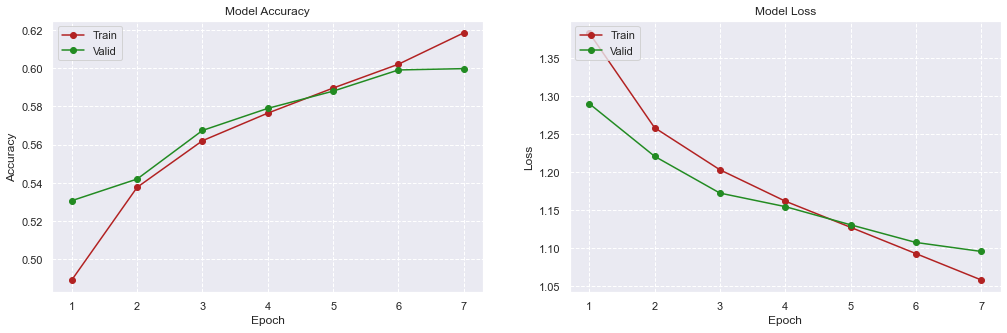

In [342]:
plot(estimator_w2v, 'lstm_W2V')

Nous observons d'une part que le modèle semble bien apprendre sur les données d'entraînement lors des 6 premières epochs. L'**accuracy** du jeu de données de validation du modèle passe en effet de 0.53 à 0.6. Cependant, à partir de la $6^{eme}$ epoch, l'**accuracy** de validation n'augmente plus, elle reste à peu près constante à partir de cette epoch. Si nous poursuivions l'entraînement du réseau, l'**accuracy** du jeu de données d'entraînement continuerait d'augmenter mais sans que le modèle ne performe mieux sur l'échantillon de validation. Cela aurait un effet de sur-apprentissage et nous observerions une croissance de la fonction de **loss** du modèle après  la $6^{eme}$ epoch. L'**accuracy** de ce réseau entraîné sur les embeddings de Word2Vec est décevante car est moins élevée que le *Support Vector Classifier* entraîné sur le TF-IDF. 

In [367]:
#model = keras.models.load_model("deep_w2v.hdf5")

In [373]:
y_prob = model.predict(X_test_input)
y_pred = y_prob.argmax(axis=-1)+1

In [388]:
labels_train, labels_test = train_test_split(df['category_1'], test_size = 0.2, random_state = 42)

La matrice de confusion nous permet d'évaluer la qualité de la classification:

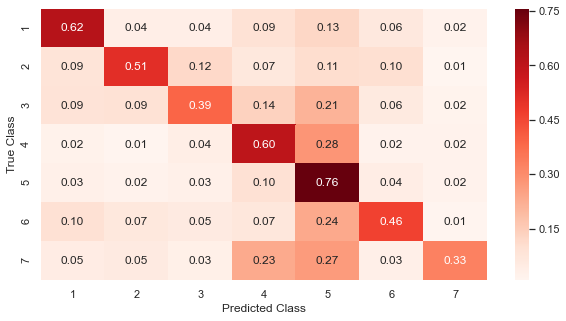

In [390]:
conf_matrix(labels_test, y_pred, "W2V_conf_matrix" )

Les résultats de cette matrice de confusion sont proches de ceux obtenus grâce au *Support Vector Classifier*. La catégorie 5 est toujours la classe la mieux prédite par le modèle avec 76% des labels de ses unités de sens correctement attribués. Nous notons que 10% de ses labels sont attribués à tort à la classe numéro 4. Ici aussi, nous observons que pour chaque catégorie, une proportion non négligeable de labels sont attribués à cette catégorie 5. La seconde catégorie dont les labels sont les mieux attribués est la catégorie 1 avec 62% d’unités de sens correctement classifiées. Là encore, le modèle commet beaucoup d’erreurs sur la labellisation des unités de sens de la catégorie 3 dont seulement 39% sont correctement labellisées. Le modèle confond cette classe principalement avec les catégories 4, 5. Finalement la catégorie dont le pourcentage d’étiquetages corrects est le plus faible est la catégorie 7 dont seulement 33% des unités de sens sont bien étiquetées. Ici aussi, cette classe est souvent confondue avec les classes 4 et 5 alors que leurs dictionnaires étaient soit-disant très éloignés.

In [391]:
print(classification_report(labels_test, y_pred))

              precision    recall  f1-score   support

           1       0.61      0.62      0.61       450
           2       0.50      0.51      0.50       281
           3       0.47      0.39      0.43       375
           4       0.62      0.60      0.61       982
           5       0.64      0.76      0.69      1489
           6       0.55      0.46      0.50       463
           7       0.56      0.33      0.42       292

    accuracy                           0.60      4332
   macro avg       0.56      0.52      0.54      4332
weighted avg       0.59      0.60      0.59      4332



Les résultats de ce classification report confirment que la classification effectuée par ce modèle est de moins bonne qualité que celle du *Support Vector Classifier*.

## FastText

In [476]:
test = df.copy()

In [477]:
from io import StringIO
import csv

col = ['lem_sent', 'category_1']

test = test[col]
test['category_1']=['__label__'+ str(s) for s in test['category_1']]
test['lem_sent']= test['lem_sent']
test.to_csv(r'/Users/paul/Desktop/STATAPP/ftext.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")

In [478]:
test.head()

,lem_sent,category_1
0,face three connect crisis heal planet effect u...,__label__4
1,create equal society reverse trend towards soc...,__label__5
2,create truly democratic central local governme...,__label__2
3,help heal planet make achieve international ag...,__label__5
4,invest billion public programme renewable elec...,__label__5


In [479]:
!head -n 16826 "/Users/paul/Desktop/STATAPP/ftext.txt" > "/Users/paul/Desktop/STATAPP/ftext_train.txt"
!tail -n 5000 "/Users/paul/Desktop/STATAPP/ftext.txt" > "/Users/paul/Desktop/STATAPP/ftext_test.txt"

In [480]:
import fasttext
model = fasttext.train_supervised("/Users/paul/Desktop/STATAPP/ftext_train.txt")

In [481]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

print_results(*model.test("/Users/paul/Desktop/STATAPP/ftext_test.txt"))

N	5000
P@1	0.583
R@1	0.583


## LSTM et FastText

In [15]:
from gensim.models.fasttext import FastText
text_dim = 200

print("Training FastText model...")

ftext_model = FastText(list(df['words']), size=text_dim, window=40, min_count=1, workers=4,sg=1)

print("FastText model created.")
print("%d unique words represented by %d dimensional vectors" % (len(ftext_model.wv.vocab), text_dim))

Training FastText model...
FastText model created.
8751 unique words represented by 200 dimensional vectors


In [16]:
word = ['economic']
similar = [word[0] for word in ftext_model.wv.most_similar(positive=word)]
similar.extend(word)

print('The most similar words to \"economic\" are: {}'.format(similar))

The most similar words to "economic" are: ['economics', 'macroeconomic', 'economical', 'socioeconomic', 'economist', 'economically', 'economy', 'eco', 'growth', 'prosperity', 'economic']


In [17]:
with warnings.catch_warnings():
    
    warnings.simplefilter("ignore", DeprecationWarning)
    X = np.zeros((200, len(similar)))
    i = 0
    names = similar.copy()
    for word in similar:
        X[0:,i] = ftext_model[word]
        i +=1

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


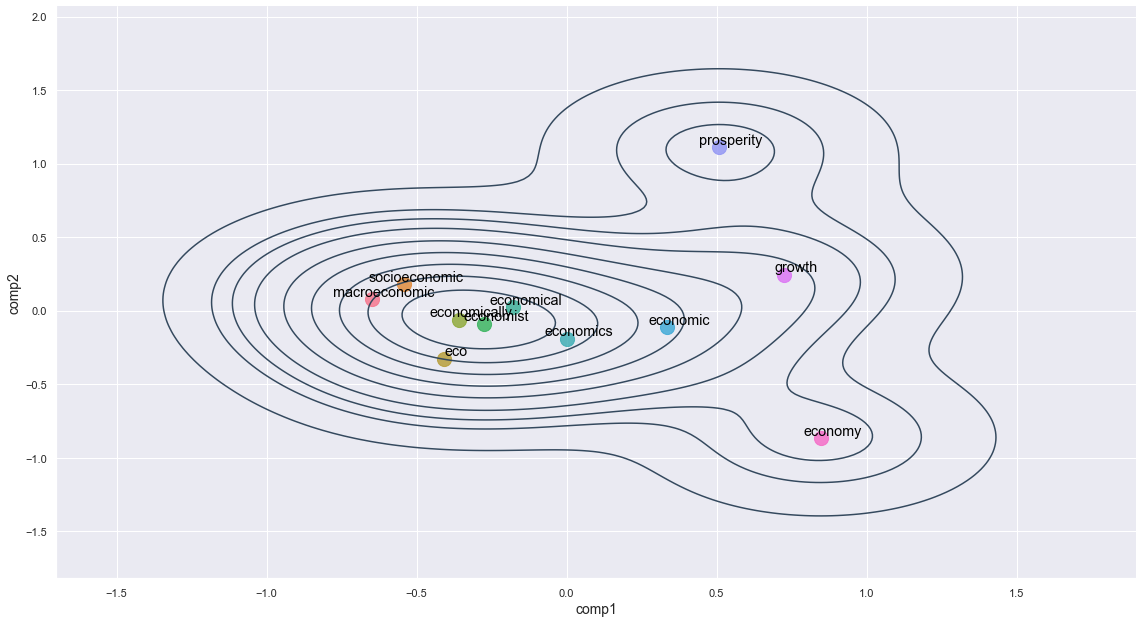

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
temp = pd.DataFrame(pca.fit_transform(X.T),columns = ["comp1", "comp2"])
temp["Name"] = names

g = sns.lmplot(x = "comp1", y = "comp2", data = temp, hue = "comp1", fit_reg = False, legend = False,
           scatter_kws = {"s":200} );

g.fig.set_figheight(10/1.1)
g.fig.set_figwidth(20/1.1)
plt.xlabel('comp1', fontsize=14)
plt.ylabel('comp2', fontsize=14)
#plt.grid(ls = 'dashed')
plt.autoscale(enable=True, axis='both', tight=None)


for line in range(len(similar)):
     plt.text(temp.comp1[line]+0.04, temp.comp2[line]+0.001, s=temp["Name"][line], horizontalalignment='center', verticalalignment='bottom',size='large', color='black', weight='light')
sns.kdeplot(temp["comp1"], temp["comp2"], color = "#34495e");


In [408]:
# save model in ASCII (word2vec) format
filename = 'embedding_fasttext.txt'
ftext_model.wv.save_word2vec_format(filename, binary=False)

In [409]:
# load embedding from file
raw_embedding = load_embedding('embedding_fasttext.txt')

In [410]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", DeprecationWarning)

    model = build_model(raw_embedding)  #('mlp')
    model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 60)           0                                            
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 60, 200)      1621200     input_19[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_19 (SpatialDr (None, 60, 200)      0           embedding_19[0][0]               
__________________________________________________________________________________________________
bidirectional_19 (Bidirectional (None, 60, 128)      135680      spatial_dropout1d_19[0][0]       
___________________________________________________________________________________________

In [411]:
transform = transformer_data_deep()
transform.fit(X_train)
X_train_input = transform.transform(X_train)
X_test_input = transform.transform(X_test)

In [412]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", DeprecationWarning)
    checkpointer = ModelCheckpoint(filepath='deep_ftext.hdf5', verbose=1,
                                               save_best_only=True, monitor='val_acc')
    
    estimator_ft = model.fit(X_train_input, y_train, epochs=7, validation_data = (X_test_input, y_test), callbacks = [checkpointer])

Train on 17328 samples, validate on 4332 samples
Epoch 1/7
17328/17328 [==============================] - 30s 2ms/step - loss: 1.3730 - acc: 0.4940 - val_loss: 1.2465 - val_acc: 0.5446

Epoch 00001: val_acc improved from -inf to 0.54455, saving model to deep_ftext.hdf5
Epoch 2/7
17328/17328 [==============================] - 29s 2ms/step - loss: 1.2263 - acc: 0.5519 - val_loss: 1.1610 - val_acc: 0.5750

Epoch 00002: val_acc improved from 0.54455 to 0.57502, saving model to deep_ftext.hdf5
Epoch 3/7
17328/17328 [==============================] - 27s 2ms/step - loss: 1.1707 - acc: 0.5731 - val_loss: 1.1537 - val_acc: 0.5840

Epoch 00003: val_acc improved from 0.57502 to 0.58403, saving model to deep_ftext.hdf5
Epoch 4/7
17328/17328 [==============================] - 30s 2ms/step - loss: 1.1249 - acc: 0.5940 - val_loss: 1.1254 - val_acc: 0.5866

Epoch 00004: val_acc improved from 0.58403 to 0.58657, saving model to deep_ftext.hdf5
Epoch 5/7
17328/17328 [==============================] - 3

In [413]:
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % 
      (100*estimator_ft.history['acc'][-1], 100*estimator_ft.history['val_acc'][-1]))

Training accuracy: 63.07% / Validation accuracy: 61.91%


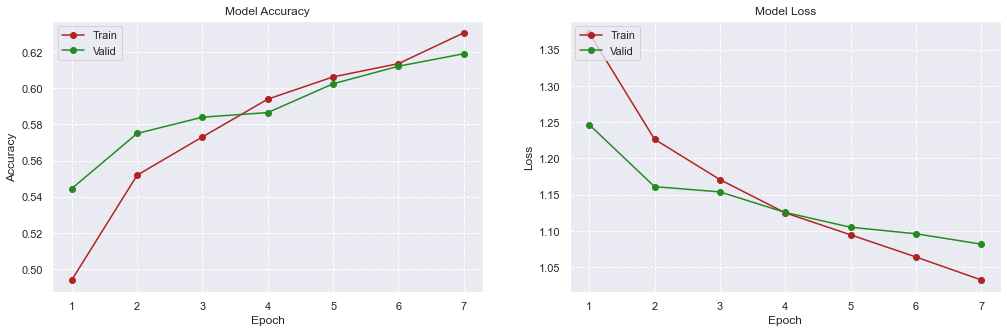

In [414]:
plot(estimator_ft, 'lstm_fasttext')

In [415]:
model = keras.models.load_model('deep_ftext.hdf5')

In [416]:
y_prob = model.predict(X_test_input)
y_pred = y_prob.argmax(axis=-1)+1
#labels_train, labels_test = train_test_split(df['category_1'], test_size = 0.2, random_state = 42)

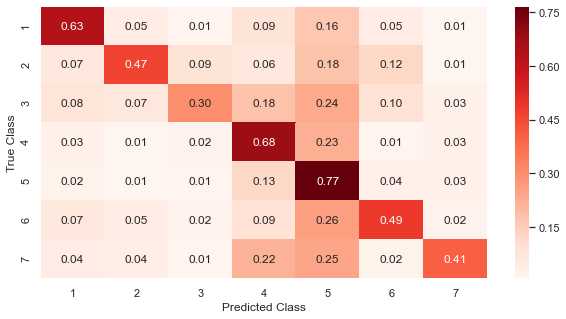

In [418]:
conf_matrix(labels_test, y_pred, 'conf_matrix_lstm_ftext')

Cette matrice de confusion obtenue en entrainant en réseau LSTM par dessus des embeddings de FastText est très similaire à celle obtenue avec des embeddings de Word2Vec. Il semblerait toutefois que la classe 3 soit moins bien classifiée de manière générale tandis qu'au contraire la classe 7 semble être légèrement mieux prédite (41% de labels correctement prédits contre 33% auparavant.)

In [419]:
print(classification_report(labels_test, y_pred))

              precision    recall  f1-score   support

           1       0.64      0.63      0.64       450
           2       0.55      0.47      0.51       281
           3       0.58      0.30      0.40       375
           4       0.61      0.68      0.65       982
           5       0.64      0.77      0.70      1489
           6       0.58      0.49      0.53       463
           7       0.57      0.41      0.48       292

    accuracy                           0.62      4332
   macro avg       0.60      0.53      0.56      4332
weighted avg       0.61      0.62      0.61      4332



## GRU et Fasttext

In [20]:
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback

In [38]:
raw_embedding = load_embedding('embedding_fasttext.txt')

In [40]:
maxlen = 60
embedding_vectors, max_features = transform.get_weight_matrix(raw_embedding)
embed_size = 200

def build_model_ftext():
    
    inp = Input(shape=(maxlen, ))
    
    x = Embedding(max_features, embed_size, weights=[embedding_vectors])(inp)
    x = SpatialDropout1D(0.2)(x)
    
    x = Bidirectional(GRU(80, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(7, activation="softmax")(conc)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

model = build_model_ftext()

In [41]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", DeprecationWarning)

    model = build_model_ftext()  #('mlp')
    model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 60, 200)      1621200     input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 60, 200)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 60, 160)      135360      spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

In [44]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", DeprecationWarning)
    
    checkpointer = ModelCheckpoint(filepath = 'Gru_ftext.hdf5', verbose = 1, 
                                   save_best_only = True, monitor = 'val_acc')
    
    estimator = model.fit(X_train_input, y_train, epochs=5, validation_data = (X_test_input, y_test), callbacks = [checkpointer])

Epoch 1/5
542/542 [==============================] - 32s 54ms/step - loss: 1.4475 - acc: 0.4662 - val_loss: 1.0470 - val_acc: 0.6311

Epoch 00001: val_acc improved from -inf to 0.63112, saving model to Gru_ftext.hdf5
Epoch 2/5
542/542 [==============================] - 30s 55ms/step - loss: 0.9619 - acc: 0.6625 - val_loss: 0.9793 - val_acc: 0.6530

Epoch 00002: val_acc improved from 0.63112 to 0.65305, saving model to Gru_ftext.hdf5
Epoch 3/5
542/542 [==============================] - 30s 55ms/step - loss: 0.7965 - acc: 0.7211 - val_loss: 0.9910 - val_acc: 0.6498

Epoch 00003: val_acc did not improve from 0.65305
Epoch 4/5
542/542 [==============================] - 30s 55ms/step - loss: 0.6701 - acc: 0.7644 - val_loss: 1.0517 - val_acc: 0.6470

Epoch 00004: val_acc did not improve from 0.65305
Epoch 5/5
542/542 [==============================] - 30s 56ms/step - loss: 0.5499 - acc: 0.8110 - val_loss: 1.1075 - val_acc: 0.6367

Epoch 00005: val_acc did not improve from 0.65305


In [45]:
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % 
      (100*estimator.history['acc'][-1], 100*estimator.history['val_acc'][-1]))

Training accuracy: 80.92% / Validation accuracy: 63.67%


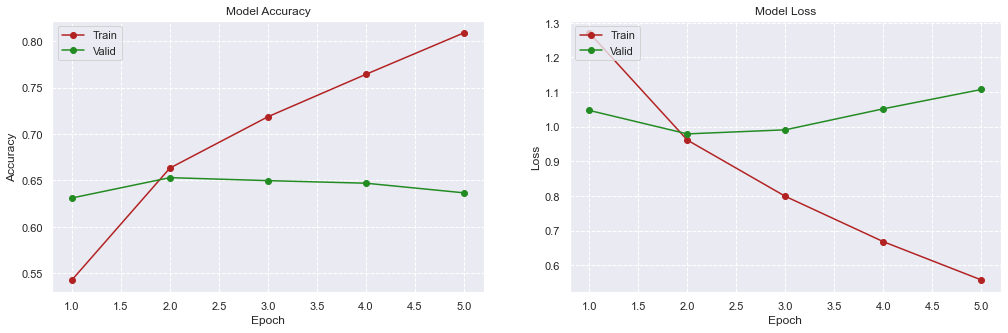

In [51]:
plot(estimator, 'Gru_ftext')

In [430]:
model = keras.models.load_model('Gru_ftext.hdf5')

/usr/local/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [431]:
y_prob = model.predict(X_test_input)
y_pred = y_prob.argmax(axis=-1)+1

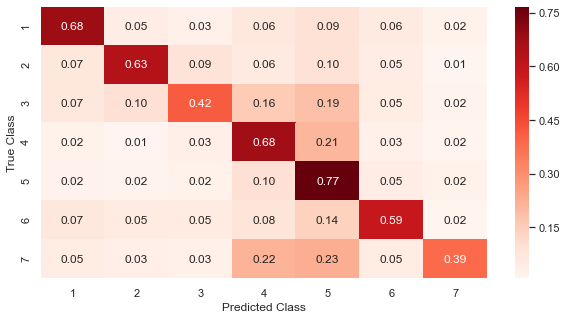

In [432]:
conf_matrix(labels_test, y_pred, 'conf_matrix_gru')

In [433]:
print(classification_report(labels_test, y_pred))

              precision    recall  f1-score   support

           1       0.67      0.68      0.68       450
           2       0.58      0.63      0.60       281
           3       0.53      0.42      0.47       375
           4       0.66      0.68      0.67       982
           5       0.71      0.77      0.74      1489
           6       0.61      0.59      0.60       463
           7       0.60      0.39      0.47       292

    accuracy                           0.65      4332
   macro avg       0.62      0.59      0.60      4332
weighted avg       0.65      0.65      0.65      4332



Cette architexture GRU permet d'obtenir des résultats quasi similaire à ceux obtenus avec un réseau LSTM mais semble en revanche souffir d'un gros problème de surapprentissage. 

Dans les notebooks suivants, nous essayons d'améliorer nos résultats de classification en utilisant *Universal Sentence Encoder* ainsi que *BERT*.

# Universal Sentence Encoder

Nous avons jusqu'ici travaillé avec des techniques de word embedding tels que Word2Vec et GloVe, qui permettent de convertir un mot en un vecteur et de déterminer ensuite si deux mots sont similaires ou non en calculant leur distance (cf. annexe pour le détail de ces méthodes). Mais lorsque l'on veut convertir une phrase en un vecteur, il faut représenter à la fois ses mots, leurs contextes, mais aussi le contexte de la phrase entière. 

Prenons par exemple les 3 phrases ci-dessous : 

1. *How old are you?*
2. *What is your age?*
3. *How are you?*

Il est évident que les phrases 1 et 2 sont identiques du point de vue sémantique, bien que la première et troisième ont plus de mots en commun. Un bon modèle devrait alors créer des vecteurs pour ces phrases tel que la distance entre les vecteurs soit plus faible entre les deux premières qu'entre la première et la troisième.

C’est pour répondre à ce besoin que l’Universal Sentence Encoder (USE) a été développé. Les plus performants à ce jour sont les deux USE pré-entraînés de Google, qui prennent comme input une chaîne de caractères, et lui associe un vecteur de dimension 512. Ils sont pré-entraînés sur des bases de données variées et ont pour objectif d'être les plus performants possible pour une grande variété de tâches de NLP. Google propose principalement deux versions : la première utilise l'architecture Transformer (Vaswani et al., 2017), tandis que la deuxième utilise un Deep Averaging Network (DAN) (Iyyer et al., 2015).L'avantage de l'USE par rapport aux word embeddings est qu'il a tendance à être bien plus performant. C'est ce que nous voulons vérifier. Pour cela, nous mettons en place la seconde architecture de l'USE de Google, qui utilise donc un DAN, que nous utilisons dans le Deep Neural Network (DNN) classifieur de Tensorflow. Il s'agit d'un réseau de neurones de type feedforward à deux couches cachées. L'architecture est peu sophistiquée puisque nous voulons observer les performances de cet embedding, même sur un modèle simple. 

In [14]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [15]:
df = pd.read_csv("./bases/ManifestoUK.csv", encoding = "latin1")

In [16]:
df = df.drop(columns = ["Unnamed: 0", "eu_code"])
df = df[df["cmp_code"] == df["cmp_code"]]
df = df[df["cmp_code"] != "H"]
df = df[df["cmp_code"] != '000'].reset_index(drop = True)

In [17]:
# Nous enlevons les cmp_code qui ne sont pas des strings
index = []

for i in range(np.shape(df)[0]):
    if type(df["text"][i]) != str:
        index.append(i)
        
df = df.drop(index).reset_index(drop = True)
df['category_1'] = df["cmp_code"].apply(lambda x: int(x[0]))

In [18]:
# Nous séparons les données en un jeu train et un jeu test

text = df['text'].values
cat1 = df['category_1'].values

train_text, test_text, train_cat1, test_cat1 = train_test_split(text, cat1, test_size=0.2, random_state=42)

train_text.shape, test_text.shape

((17333,), (4334,))

## Preprocessing

In [11]:
import contractions
from bs4 import BeautifulSoup
import unicodedata
import re

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def expand_contractions(text):
    return contractions.fix(text)

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text

def pre_process_document(document):
    # strip HTML
    document = strip_html_tags(document)
    
    # lower case
    document = document.lower()
    
    # remove extra newlines (often might be present in really noisy text)
    document = document.translate(document.maketrans("\n\t\r", "   "))
    
    # remove accented characters
    document = remove_accented_chars(document)
    
    # expand contractions    
    document = expand_contractions(document)
               
    # remove special characters and\or digits    
    # insert spaces between special characters to isolate them    
    special_char_pattern = re.compile(r'([{.(-)!}])')
    document = special_char_pattern.sub(" \\1 ", document)
    document = remove_special_characters(document, remove_digits=True)  
        
    # remove extra whitespace
    document = re.sub(' +', ' ', document)
    document = document.strip()
    
    return document

pre_process_corpus = np.vectorize(pre_process_document)

In [12]:
train_text = pre_process_corpus(train_text)
test_text = pre_process_corpus(test_text)

In [17]:
# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
    {'sentence': train_text}, train_cat1, 
    batch_size=256, num_epochs=None, shuffle=True)

In [18]:
# Prediction on the whole training set.
predict_train_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
    {'sentence': train_text}, train_cat1, shuffle=False)

In [19]:
# Prediction on the test set.
predict_test_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
    {'sentence': test_text}, test_cat1, shuffle=False)

## USE & Deep Neural Network 

In [20]:
embedding_feature = hub.text_embedding_column(
    key='sentence', 
    module_spec="https://tfhub.dev/google/universal-sentence-encoder-large/3",
    trainable=False)

In [21]:
dnn = tf.compat.v1.estimator.DNNClassifier(
          hidden_units=[512, 128],
          feature_columns=[embedding_feature],
          n_classes=8,
          activation_fn=tf.nn.relu,
          dropout=0.1)

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/var/folders/2f/3frq9y8s1mgf9ttnncktlkhw0000gn/T/tmpty4i3g1q', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/var/folders/2f/3frq9y8s1mgf9ttnncktlkhw0000gn/T/tmpty4i3g1q', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Nous entraînons ce réseau de neurones sur 80% de la base de données et sur environ 12 epochs.

In [23]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import time

TOTAL_STEPS = 1000
STEP_SIZE = 100
for step in range(0, TOTAL_STEPS+1, STEP_SIZE):
    print()
    print('-'*100)
    print('Training for step =', step)
    start_time = time.time()
    dnn.train(input_fn=train_input_fn, steps=STEP_SIZE)
    elapsed_time = time.time() - start_time
    print('Train Time (s):', elapsed_time)
    print('Eval Metrics (Train):', dnn.evaluate(input_fn=predict_train_input_fn))


----------------------------------------------------------------------------------------------------
Training for step = 0
Train Time (s): 221.00370121002197
Eval Metrics (Train): {'accuracy': 0.6109156, 'average_loss': 1.0870283, 'loss': 138.54016, 'global_step': 100}

----------------------------------------------------------------------------------------------------
Training for step = 100
Train Time (s): 213.85736393928528
Eval Metrics (Train): {'accuracy': 0.63341606, 'average_loss': 1.0201613, 'loss': 130.01805, 'global_step': 200}

----------------------------------------------------------------------------------------------------
Training for step = 200
Train Time (s): 215.2465741634369
Eval Metrics (Train): {'accuracy': 0.65810883, 'average_loss': 0.9563671, 'loss': 121.88758, 'global_step': 300}

----------------------------------------------------------------------------------------------------
Training for step = 300
Train Time (s): 220.8640079498291
Eval Metrics (Train): 

In [24]:
# Evaluation des résultats sur la base train
dnn.evaluate(input_fn=predict_train_input_fn)

{'accuracy': 0.7752841,
 'average_loss': 0.62591064,
 'loss': 79.77139,
 'global_step': 1100}

In [25]:
# Evaluation des résulats sur la base test
dnn.evaluate(input_fn=predict_test_input_fn)

{'accuracy': 0.6416705,
 'average_loss': 1.086803,
 'loss': 138.53542,
 'global_step': 1100}

In [26]:
# Fonction pour obtenir les prédictions du modèle
def get_predictions(estimator, input_fn):
    return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]
    
# Nous obtenons les prédictions sur les données de test
predictions = get_predictions(estimator=dnn, input_fn=predict_test_input_fn)
predictions[:10]

[5, 5, 5, 5, 5, 6, 6, 3, 4, 1]

In [29]:
def conf_matrix(y_true, y_pred, conf):
    C = confusion_matrix(y_true, y_pred)
        
    ConfMatrix = C / C.sum(axis=1)[:,None]
        
    plt.figure(figsize = (10, 5))
    ax = sns.heatmap(ConfMatrix, annot=True, cmap="Reds", fmt=".2f",
                xticklabels = ['1', '2', '3', '4', '5', '6', '7'], 
                yticklabels = ['1', '2', '3', '4', '5', '6', '7'])
    
    sns.set()

    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom, top)

    plt.xlabel('Predicted Class', fontsize = 12)
    plt.ylabel('True Class', fontsize = 12)
    #plt.title("Confusion Matrix", size = 14)
    plt.savefig(conf+".pdf")
    
    return plt.show()

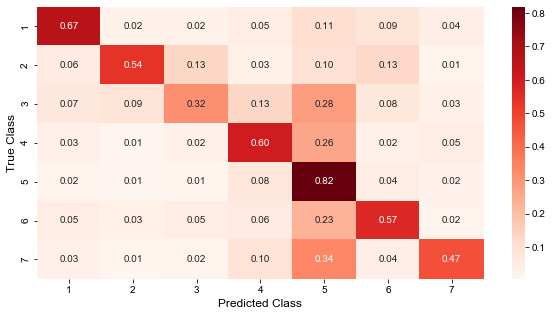

In [30]:
conf_matrix(test_cat1, predictions, "conf_matrix_use")

Les résultats de cette matrice de confusion sont proches de ceux obtenus grâce au réseau LSTM. La catégorie 5 est toujours la classe la mieux prédite par le modèle avec 82% des labels de ses unités de sens correctement attribuées, meilleur résultat qu'avec un W2V combiné à un réseau LSTM. Nous remarquons que dans la catégorie 7, 34% des unités de sens sont attribuées à tort à la catégorie 5, mais le pourcentage d’étiquetages corrects de cette catégorie a augmenté, avec 47% des unités de sens bien labellisées. Il est à noter que 28% des labels de la catégorie 3, 26% des labels de la catégorie 4 et 23% de ceux de la catégorie 6 sont attribués à tort à la catégorie 5. La seconde catégorie dont les labels sont les mieux attribués est la catégorie 1 avec 67% d’unités de sens correctement classifiées. Le modèle commet plus d'erreurs que les précédents concernant la catégorie 3, dont 32% sont correctement labellisées. Le modèle confond encore une fois cette classe principalement avec les catégories 4 et surtout 5.

In [31]:
from sklearn.metrics import classification_report

print(classification_report(y_true=test_cat1, 
                            y_pred=predictions))

              precision    recall  f1-score   support

           1       0.70      0.67      0.68       458
           2       0.63      0.54      0.58       252
           3       0.51      0.32      0.39       383
           4       0.69      0.60      0.65       974
           5       0.65      0.82      0.72      1483
           6       0.57      0.57      0.57       474
           7       0.56      0.47      0.51       310

    accuracy                           0.64      4334
   macro avg       0.62      0.57      0.59      4334
weighted avg       0.64      0.64      0.63      4334



Nous obtenons bien de meilleurs résultats qu'avec le réseau LSTM. L'**accuracy** quant à elle, est égale à celle trouvée avec le **Support Vector Classifier**, avec un score de 64%.